### Ex.1 Wilson

## 1. Simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from datetime import datetime
from scipy import special
from pathlib import Path

%matplotlib inline

In [2]:
def musk(K, chi, m, I, O_obs):
    S = np.zeros(len(O_obs))
    O_sim = np.zeros(len(O_obs))
    S[0] = K*I[0]**m
    O_sim[0] = I[0]
    for i in range(len(t)-1):
        change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
        S[i+1] = S[i] + change_rate_S
        O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
    return O_sim

In [3]:
def obj_func(X):
    O_sim = musk(*X, I, O_obs)
    return np.sum((O_obs-O_sim)**2)

## 2. Optimization

#### I. TLBO

In [4]:
def init_genrator(min_val, max_val, num_variables, pop_size):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def sorting_pop(pop, obj_func):
    results = np.apply_along_axis(obj_func, 1, pop)
    indeces = np.argsort(results)
    return pop[indeces]

def teacher_phase(pop, pop_size, obj_func):
    teacher = pop[0]
    center = np.mean(pop, axis=0)
    rand = np.random.uniform(0,1,size=(pop_size,1))
    teacher_factor = np.random.choice(np.arange(1,3), size=(pop_size,1))
    diff = rand*(teacher-center*teacher_factor)
    pop_new = pop + diff
    of = np.apply_along_axis(obj_func, 1, pop).reshape(-1,1)
    of_new = np.apply_along_axis(obj_func, 1, pop_new).reshape(-1,1)
    return np.where(of_new<of, pop_new, pop)
    
def learner_phase(pop, pop_size, obj_func):
    rand = np.random.uniform(0,1,size=(pop_size,1))
    pop_new = np.zeros_like(pop)
    for i in range(pop_size):
        x, y = np.sort(np.random.choice(np.arange(pop_size), size=2, replace=False))
        pop_new[i] = pop[i] + rand[i]*(pop[x]-pop[y])
    of = np.apply_along_axis(obj_func, 1, pop).reshape(-1,1)
    of_new = np.apply_along_axis(obj_func, 1, pop_new).reshape(-1,1)
    return np.where(of_new<of, pop_new, pop)

    
def teaching_learning_based_optimization(num_variables, min_val, max_val, pop_size, iteration, obj_func):
    NFE_value = 0
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    pop = init_genrator(min_val, max_val, num_variables, pop_size)
    pop = sorting_pop(pop, obj_func)
    for i in range(iteration):
        pop = teacher_phase(pop, pop_size, obj_func)
        pop = sorting_pop(pop, obj_func)
        pop = learner_phase(pop, pop_size, obj_func)
        pop = sorting_pop(pop, obj_func)
        NFE_value += (3*pop_size)
        NFE[i] = NFE_value
        results[i] = obj_func(pop[0])
    return pop[0], obj_func(pop[0]), results, NFE

**Results**

Parameter setting

In [5]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [6]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 500
iteration = 1000

In [7]:
start_time = time.time()

X, best_of, results, NFE = teaching_learning_based_optimization(num_variables, min_val, max_val,
                                                                pop_size, iteration, obj_func)
end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)


Best OF ====================
36.76788845642569
Variables ==================
[0.0862491  0.28691659 1.86808712]
Time ======================
Time: 5 min and 30.45 s


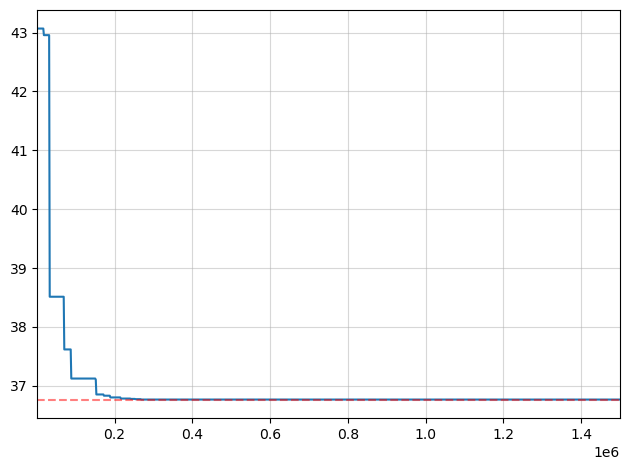

In [8]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [8]:
num_runs = 20
alg_name = 'TLBO'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = teaching_learning_based_optimization(num_variables, min_val, max_val,
                                                                pop_size, iteration, obj_func)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from

Run 1 Done in 307.87 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 2 Done in 314.22 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 3 Done in 317.10 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 4 Done in 304.08 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 5 Done in 303.27 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 6 Done in 303.49 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 7 Done in 303.58 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 8 Done in 305.41 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 9 Done in 306.96 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 10 Done in 323.47 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 11 Done in 337.51 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 12 Done in 317.33 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 13 Done in 310.45 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 14 Done in 318.31 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 15 Done in 354.50 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 16 Done in 336.12 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 17 Done in 331.71 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 18 Done in 332.87 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 19 Done in 334.63 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 20 Done in 336.09 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\452948107.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### II. WCA

In [9]:
def init_generator(pop_size, num_variables, min_val, max_val):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def sorting_pop(pop, obj_func):
    results = np.apply_along_axis(obj_func, 1, pop)
    indeces = np.argsort(results)
    return pop[indeces]

def involved_ranindrop_counter(pop, obj_func, R, S):
    costs = np.apply_along_axis(obj_func,1,pop[:R+1])
    sum_costs = np.sum(costs)
    involved_raindrops = np.round(S*np.abs(costs/sum_costs)).astype(int)
    involved_raindrops = np.insert(involved_raindrops,0,0)
    return np.cumsum(involved_raindrops)

def update_positions(pop, obj_func, R, S, C):
    involved_raindrops = involved_ranindrop_counter(pop, obj_func, R, S)
    for i in range(R+1):
        pop_reverse = pop[::-1]
        low = involved_raindrops[i]
        up = involved_raindrops[i+1]
        rand = np.random.uniform(0,1,(up-low)).reshape(-1,1)
        pop_reverse[low:up] = (pop_reverse[low:up] + rand*C*(pop[i]-pop_reverse[low:up]))
    return pop_reverse[::-1]  

def evaporation(pop, sea_threshold, min_val, max_val, search_coef):
    dist_values = np.sqrt(np.sum((pop[0]-pop)**2,1))
    replacing_index = np.array(np.argwhere((dist_values<sea_threshold)).flat)[1:]
    replacing_values = np.random.uniform(min_val, max_val, pop.shape)
    pop[replacing_index] = replacing_values[replacing_index]
    return pop

def water_cycle_algorithm(min_val, max_val, num_variables, pop_size, R, C,
                          sea_threshold, obj_func, iteration, search_coef):
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    NFE_values = 0
    pop = init_generator(pop_size, num_variables, min_val, max_val)
    pop = sorting_pop(pop, obj_func)
    NFE_values += pop_size
    S = pop_size-R-1
    for i in range(iteration):
        pop = update_positions(pop, obj_func, R, S, C)
        pop = sorting_pop(pop, obj_func)
        pop = evaporation(pop, sea_threshold, min_val, max_val, search_coef)
        pop = sorting_pop(pop, obj_func)
        sea_threshold *= (1-1/iteration)
        NFE_values += pop_size
        NFE[i] = NFE_values
        results[i] = obj_func(pop[0])
    return pop[0], obj_func(pop[0]), results, NFE

**Results**

Parameter setting

In [10]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [11]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 500
iteration = 1000
R = 5
C = 2
sea_threshold = 2
search_coef = .1

In [12]:
start_time = time.time()

X, best_of, results, NFE = water_cycle_algorithm(min_val, max_val, num_variables, pop_size, R, C,
                                                 sea_threshold, obj_func, iteration, search_coef)
end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Best OF ====================
36.77632105322676
Variables ==================
[0.08629224 0.28628256 1.86784517]
Time ======================
Time: 1 min and 48.29 s


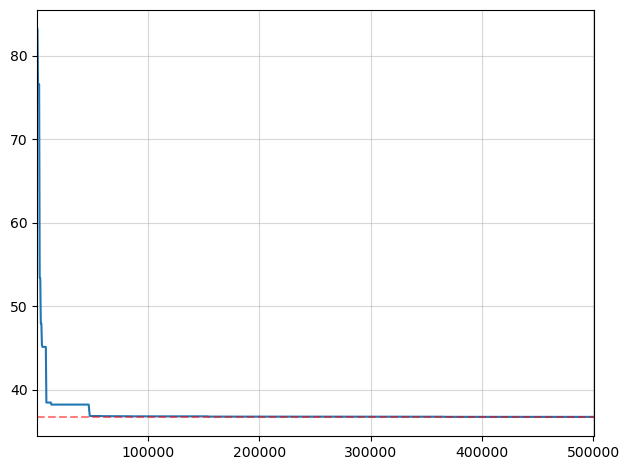

In [13]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [12]:
num_runs = 20
alg_name = 'WCS'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = water_cycle_algorithm(min_val, max_val, num_variables, pop_size,
                                                     R, C, sea_threshold, obj_func, iteration, search_coef)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed fro

Run 1 Done in 101.94 s; OF: 36.8146


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 2 Done in 99.72 s; OF: 36.7694


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 3 Done in 97.45 s; OF: 36.8098


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 4 Done in 97.08 s; OF: 36.8490


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 5 Done in 96.92 s; OF: 36.7945


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 6 Done in 97.66 s; OF: 36.8260


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 7 Done in 97.20 s; OF: 36.8115


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(

Run 8 Done in 97.60 s; OF: 36.7801


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 9 Done in 97.49 s; OF: 36.8017


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 10 Done in 97.34 s; OF: 37.2253


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 11 Done in 97.13 s; OF: 36.8201


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 12 Done in 97.61 s; OF: 36.8371


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 13 Done in 110.88 s; OF: 36.7878


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 14 Done in 110.19 s; OF: 36.9340


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 15 Done in 110.57 s; OF: 36.7746


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 16 Done in 116.41 s; OF: 36.7857


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 17 Done in 107.35 s; OF: 36.7731


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 18 Done in 97.98 s; OF: 36.7700


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 19 Done in 97.69 s; OF: 36.8468


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)


Run 20 Done in 97.53 s; OF: 36.8053


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3695799646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### III. Biogeography‐Based Optimization (BBO)

In [15]:
def init_genrator(pop_size, num_variables, min_val, max_val):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def sorting_pop(pop, obj_func):
    results = np.apply_along_axis(func1d=obj_func, axis=1, arr=pop)
    indeces = np.argsort(results)
    indeces = indeces[::-1]
    return pop[indeces]

def emigeration_probabilty(pop_size, max_emig_prob):
    return max_emig_prob*(np.arange(pop_size)+1)/pop_size

def imigeration_probabilty(pop_size, max_imig_prob):
    return max_imig_prob*(1-((np.arange(pop_size)+1)/pop_size))

def imigeration(pop, pop_size, num_variables, imigration_probs, emigration_probs):
    rand_values = np.random.uniform(0,1, pop_size)
    indeces = np.argwhere(rand_values<imigration_probs)
    for i in indeces.flat:
        rands = np.random.uniform(0,1, pop_size)
        index = np.argwhere(rands<emigration_probs)
        for j in index.flat:
            position = np.random.randint(0, num_variables)
            pop[i][position] = pop[j][position]
    return pop

def mutate(pop, pop_size, num_variables, min_val, max_val, mut_prob):
    mutation_prob_values = np.random.uniform(0,1,pop_size)
    mutation_prob_values[-1] = 1
    mut_indeces = np.argwhere(mutation_prob_values<mut_prob)
    for mut_index in mut_indeces:
        position = np.random.randint(0,num_variables)
        pop[mut_index[0]][position]=np.random.uniform(min_val,max_val)[position] #if min and max not sequance remove [position]
    return pop

def biogeography_based_optimization(pop_size, num_variables, min_val, max_val, max_imig_prob,
                                    max_emig_prob,mut_prob, iteration, obj_func):
    NFE_value = 0
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    pop = init_genrator(pop_size, num_variables, min_val, max_val)
    for i in range(iteration):
        pop = sorting_pop(pop, obj_func)
        imigration_probs = imigeration_probabilty(pop_size, max_imig_prob)
        emigration_probs = emigeration_probabilty(pop_size, max_emig_prob)
        pop = imigeration(pop, pop_size, num_variables, imigration_probs, emigration_probs)
        pop = mutate(pop, pop_size, num_variables, min_val, max_val, mut_prob)
        NFE_value += pop_size
        NFE[i] = NFE_value
        results[i] = obj_func(pop[-1])
    return pop[-1], obj_func(pop[-1]), results, NFE

**Results**

Parameter setting

In [ ]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [16]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 500
iteration = 1000
max_imig_prob = 1 #1
max_emig_prob = 1 #1
mut_prob = .2

In [214]:
start_time = time.time()

X, best_of, results, NFE = biogeography_based_optimization(pop_size, num_variables, min_val, max_val,
                                                           max_imig_prob, max_emig_prob,mut_prob,
                                                           iteration, obj_func)
end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Best OF ====================
37.50688729051514
Variables ==================
[0.1025234  0.28775641 1.82979569]
Time ======================
Time: 3 min and 18.21 s


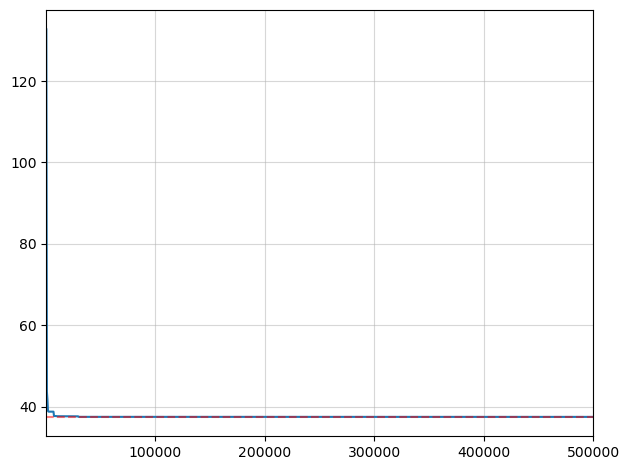

In [215]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [17]:
num_runs = 20
alg_name = 'BBO'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = biogeography_based_optimization(pop_size, num_variables, min_val, max_val,
                                                               max_imig_prob, max_emig_prob,mut_prob,
                                                               iteration, obj_func)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(

Run 1 Done in 201.90 s; OF: 45.0366


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 2 Done in 193.21 s; OF: 63.5787


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 3 Done in 192.56 s; OF: 40.2941


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 4 Done in 193.22 s; OF: 37.1589


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 5 Done in 192.29 s; OF: 38.8926


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 6 Done in 191.39 s; OF: 37.3959


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 7 Done in 193.28 s; OF: 48.1209


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 8 Done in 211.62 s; OF: 41.3585


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 9 Done in 193.16 s; OF: 58.7606


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 10 Done in 198.22 s; OF: 41.5889


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 11 Done in 193.18 s; OF: 36.7832


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 12 Done in 192.73 s; OF: 36.7792


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 13 Done in 192.83 s; OF: 65.0322


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 14 Done in 192.12 s; OF: 102.4269


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 15 Done in 191.88 s; OF: 57.8283


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 16 Done in 191.93 s; OF: 55.6349


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 17 Done in 202.07 s; OF: 37.7016


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 18 Done in 192.65 s; OF: 44.0161


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 19 Done in 193.80 s; OF: 94.8390
Run 20 Done in 193.43 s; OF: 37.0984


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1077912899.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### IV. Firecracker Algorithm

In [18]:
def initiation_point_search(N, num_var, min_val, max_val, obj_func):
    search_grid = np.random.uniform(low=min_val, high=max_val, size=(N, num_var))
    values = np.apply_along_axis(func1d=obj_func, axis=1, arr=search_grid)
    values = np.nan_to_num(values, nan=np.inf) #to deal with nan values
    index = np.argmin(values)
    return search_grid[index]

def craker_size(initial_size, iteration, alpha):
    return initial_size*(alpha**np.arange(iteration))

def sparks(init_point, craker_size, num_sparks, min_val, max_val):
    prim_vector = np.random.uniform(low=-craker_size, high=craker_size, size=(num_sparks, len(init_point)))
    landing_point = init_point + prim_vector
    landing_point = np.where(landing_point>max_val, max_val, landing_point)
    landing_point = np.where(landing_point<min_val, min_val, landing_point)
    return landing_point

def evaluate(x, obj_func):
    values = np.apply_along_axis(func1d=obj_func, axis=1, arr=x)
    index = np.argmin(values)
    return x[index], values[index]

def update_best_point(x, best_point, obj_func):
    if obj_func(x)<obj_func(best_point):
        return x, obj_func(x)
    else:
        return best_point, obj_func(best_point)
        
        
def base_point_selection(prim_loc, secondary_spark_radious, nss, best_point, 
                         base_point,min_val, max_val, obj_func):
    base_point_of=obj_func(base_point)
    for i in range(len(prim_loc)):
        secondary_sparks=sparks(init_point=prim_loc[i],craker_size=secondary_spark_radious,
                                num_sparks=nss,min_val=min_val,max_val=max_val)
        all_sparks=np.concatenate((np.reshape(prim_loc[i],(1,-1)),secondary_sparks),axis=0)
        avr_appeal=np.average(np.apply_along_axis(func1d=obj_func, axis=1, arr=all_sparks))
        best_loc_point, best_loc_of = evaluate(all_sparks,obj_func)
        best_point, best_of = update_best_point(best_loc_point, best_point, obj_func)
        if avr_appeal<base_point_of:
            base_point=np.average(all_sparks,axis=0)
            base_point_of=avr_appeal 
    return base_point, best_point, best_of

    
def firecracker_algorithm(N, num_var, min_val, max_val, obj_func, nps, nss,
                          iteration, alpha, psr_0, ssr_0):
    NFE_value = 0
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    base_point = initiation_point_search(N, num_var, min_val, max_val, obj_func)
    NFE_value += N
    base_point_of = obj_func(base_point)
    best_point = base_point
    best_of = base_point_of
    primary_spark_radiouses=craker_size(psr_0, iteration, alpha)
    secondary_spark_radiouses=craker_size(ssr_0, iteration, alpha)
    for i in range(iteration):
        prim_loc = sparks(base_point, primary_spark_radiouses[i], nps, min_val, max_val)
        a, b, c = base_point_selection(prim_loc, secondary_spark_radiouses[i], nss, best_point, 
                                          base_point, min_val, max_val, obj_func)
        base_point, best_point, best_of = a, b, c
        NFE_value += (nss+nps)
        NFE[i] = NFE_value
        results[i]= best_of
    return best_point, best_of, results, NFE

In [19]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [20]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

N = 100
psr_0 = max(np.array(max_val)-np.array(min_val))/2
ssr_0 = psr_0/5 
nps = 100 #100 
nss = 5 #5
alpha = .98
iteration = 1000

In [24]:
start_time = time.time()

X, best_of, results, NFE = firecracker_algorithm(N, num_variables, min_val, max_val, obj_func, nps, nss,
                                                 iteration, alpha, psr_0, ssr_0)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Best OF ====================
36.76788845646302
Variables ==================
[0.08624921 0.2869166  1.86808684]
Time ======================
Time: 2 min and 46.55 s


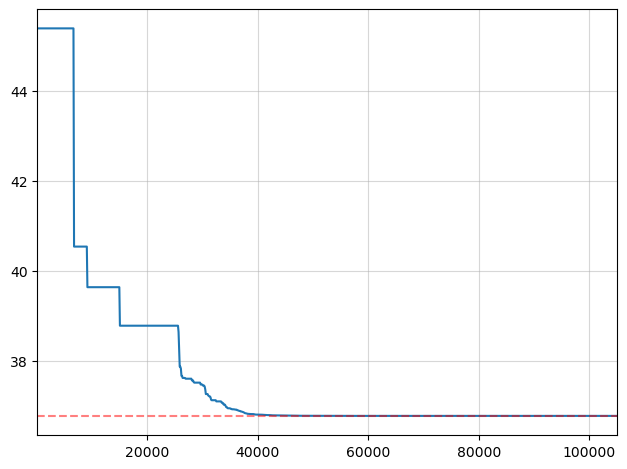

In [25]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [21]:
num_runs = 20
alg_name = 'FC'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'


overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = firecracker_algorithm(N, num_variables, min_val, max_val, obj_func, nps, nss,
                                                     iteration, alpha, psr_0, ssr_0)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(

Run 1 Done in 159.61 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 2 Done in 161.29 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 3 Done in 163.92 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 4 Done in 156.89 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 5 Done in 157.00 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 6 Done in 157.32 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 7 Done in 159.59 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 8 Done in 157.30 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 9 Done in 157.38 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 10 Done in 156.64 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 11 Done in 158.58 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 12 Done in 158.08 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 13 Done in 157.69 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 14 Done in 156.81 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 15 Done in 157.47 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 16 Done in 157.26 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 17 Done in 161.08 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 18 Done in 159.20 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 19 Done in 161.55 s; OF: 36.7679
Run 20 Done in 163.60 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2841322125.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### V. Genetic Algorithm (GA)

In [22]:
def init_generator(num_variable, pop_size, min_val, max_val):
    return np.random.uniform(low=min_val,high=max_val,size=(pop_size,num_variable))

def selection(pop, obj_func, R):
    of = np.apply_along_axis(func1d=obj_func,axis=1,arr=pop)
    index = np.argsort(of)
    return pop[index][:R]
        
def cross_over(pop, pc):
    index = np.random.uniform(size=len(pop))
    selected_parents = pop[index<=pc]
    parents_indeces = np.random.randint(0,len(selected_parents),size=(2,len(selected_parents)//2))
    parents_1, parents_2 = selected_parents[parents_indeces[0]], selected_parents[parents_indeces[1]]
    crossover_index = np.random.randint(0,2,pop.shape[1])
    childs_1 = np.where(crossover_index,parents_1,parents_2)
    childs_2 = np.where(crossover_index,parents_2,parents_1)
    childs = np.concatenate((childs_1,childs_2),axis=0)
    return childs

        
def mutation(pop,pm,min_val,max_val,current_iteration,iteration):
    indeces = np.random.uniform(size=pop.shape)<pm
    mutated_values = init_generator(pop.shape[1],pop.shape[0],min_val,max_val)
    mutated_pop = np.where(indeces,mutated_values,pop)
    return mutated_pop
        
def GA_algorithem(pop_size, num_variable, obj_func, R,
                  min_val, max_val, pm, pc, iteration):
    results=np.zeros(iteration)
    NFE=np.zeros(iteration)
    NFE_value=0
    pop=init_generator(num_variable,pop_size,min_val,max_val)
    for i in range(iteration):
        selected_parents=selection(pop,obj_func,R)
        NFE_value+=pop_size
        childs=cross_over(selected_parents,pc)
        mutated_childs=mutation(pop,pm,min_val,max_val,i,iteration)
        all_results=np.concatenate((pop,childs,mutated_childs),axis=0)
        pop=selection(all_results,obj_func,pop_size)
        NFE_value+=len(all_results)
        results[i]=obj_func(pop[0])
        NFE[i]=NFE_value
    return pop[0], obj_func(pop[0]), results, NFE

In [23]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [24]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size=750
iteration=1500
R=50
pm=.2 #.2
pc=.4 #.7

In [219]:
start_time = time.time()

X, best_of, results, NFE = GA_algorithem(pop_size, num_variables, obj_func, R,
                                         min_val, max_val, pm, pc, iteration)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Best OF ====================
36.82990855364713
Variables ==================
[0.08202425 0.28658774 1.8791936 ]
Time ======================
Time: 5 min and 32.07 s


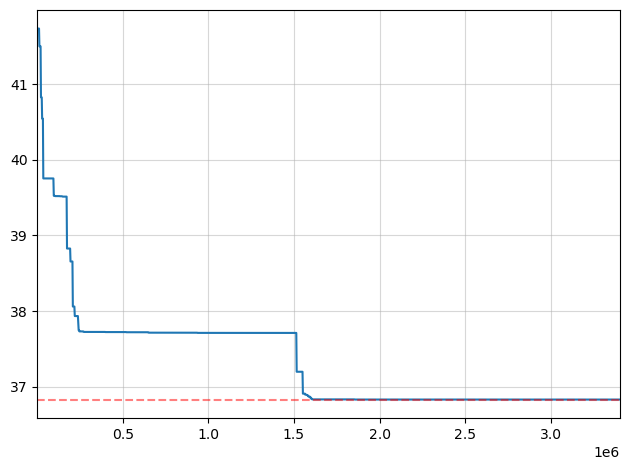

In [220]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [25]:
num_runs = 20
alg_name = 'GA'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = GA_algorithem(pop_size, num_variables, obj_func, R,
                                             min_val, max_val, pm, pc, iteration)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(

Run 1 Done in 337.85 s; OF: 36.8824


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 2 Done in 337.63 s; OF: 36.8361


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 3 Done in 338.67 s; OF: 37.0419


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 4 Done in 336.32 s; OF: 37.4088


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 5 Done in 347.08 s; OF: 36.7841


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 6 Done in 346.14 s; OF: 37.2799


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 7 Done in 348.48 s; OF: 36.7755


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 8 Done in 329.92 s; OF: 36.8108


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 9 Done in 323.44 s; OF: 36.8338


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 10 Done in 333.44 s; OF: 36.7817


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 11 Done in 335.16 s; OF: 36.8670


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 12 Done in 333.60 s; OF: 36.7709


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 13 Done in 333.83 s; OF: 36.7680


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 14 Done in 334.75 s; OF: 36.7763


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 15 Done in 341.82 s; OF: 37.8265


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 16 Done in 326.43 s; OF: 37.3469


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 17 Done in 330.56 s; OF: 36.8575


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 18 Done in 350.57 s; OF: 36.8197


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 19 Done in 332.83 s; OF: 37.2426
Run 20 Done in 334.05 s; OF: 36.9807


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3136848887.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### VI. Differential Evolution (DE)

In [26]:
def init_generator(num_variables, pop_size, min_val, max_val):
    return np.random.uniform(min_val, max_val, size=(pop_size, num_variables))

def mutation_index_system(pop_size):
    index_set = np.zeros((pop_size,pop_size), dtype=int) + np.arange(pop_size)
    dropable_index = (pop_size+1)*np.arange(pop_size)
    return np.reshape(np.delete(index_set, dropable_index), (pop_size, pop_size-1))

def mutation(pop, index, mutation_factor, min_val, max_val):
    pop_size = len(pop)
    mut_pop = np.zeros_like(pop)
    for i in range(pop_size):
        a,b,c = np.random.choice(index[i],3,replace=False)
        mut_pop[i]=pop[a]+mutation_factor*(pop[b]-pop[c])
        
    mut_pop=np.where(mut_pop>max_val, max_val, mut_pop)
    mut_pop=np.where(mut_pop<min_val, min_val, mut_pop)
    return mut_pop

def crossover(pop,mut_pop, p_crossover):
    prob=np.random.uniform(size=(pop.shape[0],pop.shape[1]))
    b_index=np.random.randint(0,pop.shape[1],size=pop.shape[0])
    for i in range(prob.shape[0]):
        prob[i][b_index[i]]=0
    return np.where(prob<p_crossover,mut_pop,pop)

def merge(pop, crossover_pop, obj_func):
    result = np.apply_along_axis(func1d=obj_func, axis=1, arr=pop)
    result = np.nan_to_num(result, nan=np.inf) #to deal with nan values
    cross_result = np.apply_along_axis(func1d=obj_func, axis=1, arr=crossover_pop)
    cross_result = np.nan_to_num(cross_result, nan=np.inf) #to deal with nan values
    replacing_index = np.argwhere(cross_result<result)
    pop[replacing_index]=crossover_pop[replacing_index]
    return pop

def evaluation(pop, obj_func):
    result = np.apply_along_axis(func1d=obj_func, axis=1, arr=pop)
    result = np.nan_to_num(result, nan=np.inf) #to deal with nan values
    index = np.argmin(result)
    return pop[index], result[index]

def DE_algorithem(num_variables, min_val, max_val, obj_func, pop_size, 
                  mutation_factor, p_crossover, iteration):
    results=np.zeros(iteration)
    NFE=np.zeros(iteration)
    NFE_value=0
    index = mutation_index_system(pop_size)
    pop=init_generator(num_variables, pop_size, min_val, max_val)
    for i in range(iteration):
        mut_pop=mutation(pop, index, mutation_factor, min_val, max_val)
        crossover_pop=crossover(pop, mut_pop, p_crossover)
        pop=merge(pop, crossover_pop, obj_func)
        NFE_value+=pop_size
        NFE[i]=NFE_value
        results[i]=evaluation(pop, obj_func)[1]
    X, best_of = evaluation(pop, obj_func)
    return X, best_of, results, NFE

In [27]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [28]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size=500
iteration=1000
mutation_factor = 0.5
p_crossover=.5

In [34]:
start_time = time.time()

X, best_of, results, NFE = DE_algorithem(num_variables, min_val, max_val, obj_func, pop_size, 
                                         mutation_factor, p_crossover, iteration)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Best OF ====================
36.76788845642553
Variables ==================
[0.0862491  0.2869166  1.86808711]
Time ======================
Time: 2 min and 52.70 s


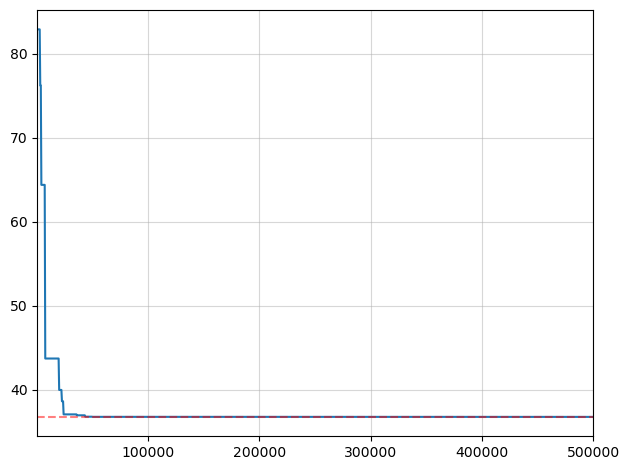

In [35]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [29]:
num_runs = 20
alg_name = 'DE'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = DE_algorithem(num_variables, min_val, max_val, obj_func, pop_size, 
                                             mutation_factor, p_crossover, iteration)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S

Run 1 Done in 160.87 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 2 Done in 157.38 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 3 Done in 155.30 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 4 Done in 165.07 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 5 Done in 159.76 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 6 Done in 158.45 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 7 Done in 156.10 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 8 Done in 157.99 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 9 Done in 166.58 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 10 Done in 159.05 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 11 Done in 159.98 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 12 Done in 163.13 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 13 Done in 186.18 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 14 Done in 182.17 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 15 Done in 171.68 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 16 Done in 165.27 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 17 Done in 164.25 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 18 Done in 161.56 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 19 Done in 162.31 s; OF: 36.7679
Run 20 Done in 161.23 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\457847279.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### VII. Bat Algorithm (BA)

In [30]:
def init_generator(pop_size, num_variables, min_val, max_val):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def frequancy(frequency_min, frequancy_max):
    return np.random.uniform(frequency_min, frequancy_max)

def sort_pop(pop, obj_func):
    results = np.apply_along_axis(obj_func, 1, pop)
    index = np.argsort(results)
    return pop[index]

def velocity_calculator(pop, velocity_values, frequancy_val, xbest):
    return velocity_values + frequancy_val*(xbest-pop)

def pulsation_rate(final_pulse, C1, iteration):
    return final_pulse*(1-np.exp(-C1*np.arange(iteration)))

def loudness(initial_loudness, C2, iteration):
    return initial_loudness*C2**np.arange(iteration)

def random_fly(pop, pop_size, num_variables, obj_func, loudness_value):
    index = np.random.randint(pop_size)
    rand = np.random.uniform(-1,1,num_variables)
    new_x = pop[index] + (rand*loudness_value)
    if obj_func(new_x)<obj_func(pop[index]):
        pop[index]=new_x     
    return pop

def bat_algorithm(pop_size, num_variables, min_val, max_val, frequency_min, frequancy_max, obj_func,
                  final_pulse, initial_loudness, C1, C2, iteration):
    NFE_value = 0
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    pop = init_generator(pop_size, num_variables, min_val, max_val)
    pop = sort_pop(pop, obj_func)
    xbest = pop[0]
    velocity_values = np.zeros_like(pop)
    pulse_values = pulsation_rate(final_pulse, C1, iteration)
    loudness_value = loudness(initial_loudness, C2, iteration)
    for i in range(iteration):
        frequancy_val = frequancy(frequency_min, frequancy_max)
        velocity_values = velocity_calculator(pop, velocity_values, frequancy_val, xbest)
        pop += velocity_values
        if np.random.uniform(0,1)>pulse_values[i]:
            pop = random_fly(pop, pop_size, num_variables, obj_func, loudness_value[i])
        if np.random.uniform(0,1)<loudness_value[i]:
            pop = random_fly(pop, pop_size, num_variables, obj_func, loudness_value[i])
        pop = sort_pop(pop, obj_func)
        xbest = pop[0]
        NFE_value += pop_size
        NFE[i] = NFE_value
        results[i] = obj_func(pop[0])
    return pop[0], obj_func(pop[0]), results, NFE

In [31]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [32]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 1000
iteration = 1750
frequency_min, frequancy_max = 0, 1
final_pulse = 1
initial_loudness = 1
C1 = 1.5 #1.5
C2 = .3 #.3

In [ ]:
start_time = time.time()

X, best_of, results, NFE = bat_algorithm(pop_size, num_variables, min_val, max_val, frequency_min,
                                         frequancy_max, obj_func,
                                         final_pulse, initial_loudness, C1, C2, iteration)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

In [ ]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [33]:
num_runs = 20
alg_name = 'BA'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = bat_algorithm(pop_size, num_variables, min_val, max_val, frequency_min,
                                             frequancy_max, obj_func,
                                             final_pulse, initial_loudness, C1, C2, iteration)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\L

Run 1 Done in 185.12 s; OF: 49.7533


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 2 Done in 185.16 s; OF: 43.9231


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\238192463.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid valu

Run 3 Done in 186.32 s; OF: 37.9748


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\238192463.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'

Run 4 Done in 198.84 s; OF: 48.9296


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 5 Done in 197.33 s; OF: 51.2048


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\238192463.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'

Run 6 Done in 199.47 s; OF: 45.8207


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\238192463.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'

Run 7 Done in 184.57 s; OF: 47.6338


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykerne

Run 8 Done in 186.05 s; OF: 41.0697


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\238192463.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'

Run 9 Done in 182.10 s; OF: 52.5746


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykerne

Run 10 Done in 184.51 s; OF: 38.7856


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 11 Done in 182.04 s; OF: 49.1561


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykerne

Run 12 Done in 182.84 s; OF: 44.7363


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 13 Done in 182.39 s; OF: 47.2093


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 14 Done in 189.23 s; OF: 41.6186


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 15 Done in 181.26 s; OF: 58.0518


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\238192463.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'

Run 16 Done in 182.97 s; OF: 42.7399


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\238192463.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid valu

Run 17 Done in 188.19 s; OF: 39.0713


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 18 Done in 199.72 s; OF: 45.2603


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 19 Done in 182.34 s; OF: 44.2665


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m


Run 20 Done in 182.20 s; OF: 41.5894


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\238192463.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### VIII. Survivalists algorithm (SA)

In [34]:
def init_generator(num_survivalists, num_variables, min_val, max_val):
    return np.random.uniform(min_val, max_val, (num_survivalists, num_variables))

def neighbor_selector(pop, current_index, radius):
    dist = np.sqrt(np.sum((pop[current_index]-pop)**2, axis = 1))
    indeces = np.argwhere(dist<radius)
    return pop[indeces.flat]

def sorting_generation(pop, obj_func):
    results = np.apply_along_axis(obj_func, 1, pop)
    indeces = np.argsort(results)
    return pop[indeces]

def best_worst_point_finder(sorted_pop):
    return sorted_pop[0], sorted_pop[-1]

def neighbor_based_moves(x, sorted_neighbor):
    len_neighbor = len(sorted_neighbor)
    if len_neighbor>1:
        center = np.sum(sorted_neighbor, axis=0)/len_neighbor
        locbest, locworst = sorted_neighbor[0], sorted_neighbor[-1]
        rand = np.random.uniform(0, 1, 3)
        gathering_move_vector = rand[0]*(center-x)
        attraction_move_vector = rand[1]*(locbest-x)
        detraction_move_vector = rand[2]*(x-locworst)
        return gathering_move_vector+attraction_move_vector+detraction_move_vector
    else:
        return np.zeros_like(x)
    
def generation_based_moves(x, xbest, xworst):
    rand = np.random.uniform(0, 1, 2)
    attraction_move_vector = rand[0]*(xbest-x)
    detraction_move_vector = rand[1]*(x-xworst)
    return attraction_move_vector+detraction_move_vector

def survivalists_move(pop, num_survivalists, obj_func, radius, xbest, xworst):
    move_vector = np.zeros_like(pop)
    for i in range(1, num_survivalists):
        neighbor = neighbor_selector(pop, i, radius)
        sorted_neighbor = sorting_generation(neighbor, obj_func)
        loc_move = neighbor_based_moves(pop[i], sorted_neighbor)
        glob_move = generation_based_moves(pop[i], xbest, xworst)
        move_vector[i] = loc_move+glob_move
    return move_vector

def boundery_check(new_pop, min_val, max_val):
    new_pop=np.where(new_pop>max_val, max_val, new_pop)
    new_pop=np.where(new_pop<min_val, min_val, new_pop)
    return new_pop

def mutation(new_pop, radius, xbest, mut_prob):
    prob = np.random.uniform(0, 1, (new_pop.shape[0], new_pop.shape[1]))
    mut_values = np.random.normal(0, radius, (new_pop.shape[0], new_pop.shape[1]))+xbest
    mut_values = boundery_check(mut_values, min_val, max_val)
    return np.where(prob<mut_prob, mut_values, new_pop)

def crossover(new_pop, pop, cross_prob):
    prob = np.random.uniform(size=(pop.shape[0],pop.shape[1]))
    return np.where(prob<cross_prob, pop, new_pop)

def greedy_combine(pop, new_pop, obj_func):
    result = np.apply_along_axis(func1d=obj_func, axis=1, arr=pop)
    new_result = np.apply_along_axis(func1d=obj_func, axis=1, arr=new_pop)
    replacing_index = np.argwhere(new_result<result)
    pop[replacing_index]=new_pop[replacing_index]
    return pop

def radius_calculator(iteration, alpha, num_variables, min_val, max_val):
    if not isinstance(min_val, (float, int)):#FIX FOR ARRAYS
        min_val = np.mean(min_val)
    if not isinstance(max_val, (float, int)):#FIX FOR ARRAYS
        max_val = np.mean(max_val)
    r_final = np.sqrt(num_variables*((max_val-min_val)/2)**2)
    radius_values = r_final*alpha**np.arange(iteration)
    return radius_values[::-1]

def survivalists_algorithm(num_survivalists, num_variables, min_val, max_val, obj_func,
                           mut_prob, cross_prob, iteration, alpha):
    NFE_value = 0
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    radius_values = radius_calculator(iteration, alpha, num_variables, min_val, max_val)
    pop = init_generator(num_survivalists, num_variables, min_val, max_val)
    pop = sorting_generation(pop, obj_func)
    xbest, xworst = best_worst_point_finder(pop)
    NFE_value += num_survivalists
    for j in range(iteration):
        radius = radius_values[j]
        moving_vector = survivalists_move(pop, num_survivalists, obj_func, radius, xbest, xworst)
        new_pop = pop+moving_vector
        new_pop = boundery_check(new_pop, min_val, max_val)
        new_pop = mutation(new_pop, radius, xbest, mut_prob)
        new_pop = crossover(new_pop, pop, cross_prob)
        pop = greedy_combine(pop, new_pop, obj_func)
        pop = sorting_generation(pop, obj_func)
        xbest, xworst = best_worst_point_finder(pop)
        results[j] = obj_func(xbest)
        NFE_value += num_survivalists
        NFE[j] = NFE_value
    return xbest, obj_func(xbest), results, NFE

In [35]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [36]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

num_survivalists = 250#500
iteration = 200#1000
mut_prob = .3 
cross_prob = .4 
alpha = .98

In [53]:
start_time = time.time()

X, best_of, results, NFE = survivalists_algorithm(num_survivalists, num_variables, min_val, max_val, obj_func,
                                                  mut_prob, cross_prob, iteration, alpha)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Best OF ====================
36.981935890101255
Variables ==================
[0.09377494 0.2869878  1.84994218]
Time ======================
Time: 7 min and 39.58 s


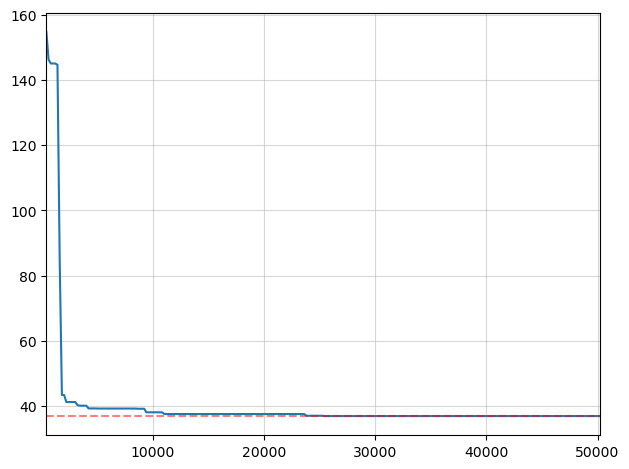

In [55]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [37]:
num_runs = 20
alg_name = 'SA_u'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = survivalists_algorithm(num_survivalists, num_variables, min_val, max_val, obj_func,
                                                      mut_prob, cross_prob, iteration, alpha)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(

Run 1 Done in 698.06 s; OF: 36.9918


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 2 Done in 702.76 s; OF: 36.7745


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 3 Done in 686.64 s; OF: 36.8332


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 4 Done in 680.38 s; OF: 36.8586


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 5 Done in 597.72 s; OF: 36.8370


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 6 Done in 549.33 s; OF: 36.9725


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 7 Done in 531.12 s; OF: 36.8943


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 8 Done in 505.18 s; OF: 37.2173


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 9 Done in 560.21 s; OF: 37.4463


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 10 Done in 875.42 s; OF: 36.8524


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 11 Done in 578.40 s; OF: 37.2402


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 12 Done in 726.10 s; OF: 37.0423


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 13 Done in 681.15 s; OF: 37.0137


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 14 Done in 796.62 s; OF: 36.7906


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 15 Done in 629.90 s; OF: 36.8316


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 16 Done in 670.52 s; OF: 36.8000


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 17 Done in 739.93 s; OF: 37.2057


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 18 Done in 745.52 s; OF: 36.7862


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 19 Done in 449.52 s; OF: 37.2471
Run 20 Done in 666.18 s; OF: 36.8796


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2985004658.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### IX. Crow Search Algorithm (CSA)

In [38]:
def init_generator(pop_size, num_variables, min_val, max_val):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def best_solution(memory, obj_func):
    results = np.apply_along_axis(obj_func, 1, memory)
    results = np.nan_to_num(results, nan=np.inf) #to deal with nan values
    index = np.argmin(results)
    return memory[index]

def update_memory(pop, memory, obj_func):
    pop_of = np.apply_along_axis(obj_func, 1, pop)
    pop_of = np.nan_to_num(pop_of, nan=np.inf) #to deal with nan values
    memory_of = np.apply_along_axis(obj_func, 1, memory)
    memory_of = np.nan_to_num(memory_of, nan=np.inf) #to deal with nan values
    replacing_index = np.argwhere(pop_of<memory_of)
    memory[replacing_index]=pop[replacing_index]
    return memory

def movment(pop, memory, pop_size, flight_lenght, awarness_prob):
    rand_index = np.random.uniform(0,1,(pop_size))
    rand_pop = init_generator(pop_size, num_variables, min_val, max_val)
    detected_index = np.array(np.argwhere(awarness_prob>rand_index).flat)
    prey_index = np.random.choice(np.arange(pop_size), pop_size, replace=False)
    memory_rand = memory[prey_index]
    new_pop = pop + flight_lenght*np.random.uniform(0,1, (pop_size, 1))*(memory_rand-pop)
    new_pop[detected_index]=rand_pop[detected_index]
    return new_pop

def crow_search_algorithm(num_variables, pop_size, min_val, max_val, flight_lenght,
                          obj_func, awarness_prob, iteration):
    NFE_value = 0
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    pop = init_generator(pop_size, num_variables, min_val, max_val)
    memory = pop.copy()
    for i in range(iteration):
        pop = movment(pop, memory, pop_size, flight_lenght, awarness_prob)
        memory = update_memory(pop, memory, obj_func)
        NFE_value += pop_size
        results[i] = obj_func(best_solution(memory, obj_func))
        NFE[i] = NFE_value
    X  = best_solution(memory, obj_func)
    return X, obj_func(X), results, NFE

In [ ]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [39]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 500
iteration = 1000
flight_lenght = 1
awarness_prob = .4

In [58]:
start_time = time.time()

X, best_of, results, NFE = crow_search_algorithm(num_variables, pop_size, min_val, max_val, flight_lenght,
                                                 obj_func, awarness_prob, iteration)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Best OF ====================
36.78910730951768
Variables ==================
[0.08841753 0.28767397 1.86258356]
Time ======================
Time: 2 min and 36.95 s


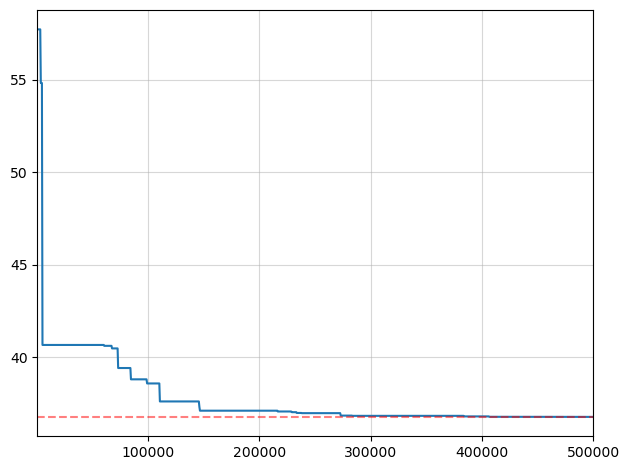

In [59]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [40]:
num_runs = 20
alg_name = 'CSA'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = crow_search_algorithm(num_variables, pop_size, min_val, max_val, flight_lenght,
                                                     obj_func, awarness_prob, iteration)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(

Run 1 Done in 144.31 s; OF: 36.7724


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 2 Done in 144.44 s; OF: 36.7793


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 3 Done in 144.35 s; OF: 37.1757


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 4 Done in 144.39 s; OF: 36.7751


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 5 Done in 144.21 s; OF: 36.7797


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 6 Done in 144.34 s; OF: 36.8038


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 7 Done in 144.80 s; OF: 36.7797


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 8 Done in 144.60 s; OF: 36.7699


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 9 Done in 144.54 s; OF: 36.7737


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 10 Done in 144.48 s; OF: 36.7684


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 11 Done in 143.44 s; OF: 36.7874


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 12 Done in 144.82 s; OF: 36.9170


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 13 Done in 144.11 s; OF: 36.7752


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 14 Done in 144.49 s; OF: 36.7692


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 15 Done in 144.31 s; OF: 36.8891


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 16 Done in 144.63 s; OF: 36.7707


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 17 Done in 144.36 s; OF: 36.7699


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 18 Done in 144.43 s; OF: 37.0225


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 19 Done in 144.07 s; OF: 36.7839
Run 20 Done in 144.27 s; OF: 36.8736


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\4224915721.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### X. Particle Swarm Optimization (PSO)

In [41]:
def init_generation(num_variables, pop_size, min_val, max_val):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def boundery_check(new_pop, min_val, max_val):
    new_pop=np.where(new_pop>max_val, max_val, new_pop)
    new_pop=np.where(new_pop<min_val, min_val, new_pop)
    return new_pop

def best_solution(pop, obj_func):
    result = np.apply_along_axis(func1d=obj_func, axis=1, arr=pop)
    result = np.nan_to_num(result, nan=np.inf) #to deal with nan values
    index = np.argmin(result)
    return (pop[index], result[index])

def merge(pop, new_pop, obj_func):
    result = np.apply_along_axis(func1d=obj_func, axis=1, arr=pop)
    result = np.nan_to_num(result, nan=np.inf) #to deal with nan values
    new_result = np.apply_along_axis(func1d=obj_func, axis=1, arr=new_pop)
    new_result = np.nan_to_num(new_result, nan=np.inf) #to deal with nan values
    index = np.reshape(result>new_result,newshape=(-1,1))
    merge = np.where(index,new_pop,pop)
    return merge

def inertia_computation(inertia_0, inertia_final, iteration):
    return inertia_0-((np.arange(1,iteration+1)/iteration)*(inertia_0-inertia_final))

def update_velocity(pop, pbest, inertia, velocity, gbest, cognative_param,
                    social_param, upper_velocity, lower_velocity):
    rand = np.random.uniform(size=(pop.shape[0], pop.shape[1]))
    new_velocity=(velocity*inertia)+(cognative_param*rand*(pbest-pop))+(social_param*rand*(gbest[0]-pop))
    new_velocity=np.where(new_velocity>upper_velocity,upper_velocity,new_velocity)
    new_velocity=np.where(new_velocity<lower_velocity,lower_velocity,new_velocity)
    return new_velocity

def PSO_algorithem(num_variables, pop_size, min_val, max_val, obj_func, inertia_0, 
                   inertia_final, iteration, cognative_param, social_param,
                   upper_velocity=np.inf, lower_velocity=-np.inf):
    results=np.zeros(iteration)
    NFE=np.zeros(iteration)
    NFE_value=0
    inertia_values = inertia_computation(inertia_0, inertia_final, iteration)
    pop=init_generation(num_variables, pop_size, min_val, max_val)
    NFE_value+=pop_size
    pbest=pop.copy()
    gbest=best_solution(pbest, obj_func)
    velocity=np.zeros_like(pop)
    for i in range(iteration):
        velocity=update_velocity(pop, pbest, inertia_values[i], velocity, gbest,
                                 cognative_param, social_param, upper_velocity, lower_velocity)
        pop+=velocity
        pbest=merge(pop, pbest, obj_func)
        pbest = boundery_check(pbest,min_val,max_val)
        gbest=best_solution(pbest, obj_func)
        NFE_value+=pop_size
        NFE[i]=NFE_value
        results[i]=gbest[1]
    return gbest[0], gbest[1], results, NFE

In [ ]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [42]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 1000
iteration = 1750
inertia_0 = .8
inertia_final = .4
cognative_param = 2
social_param = 2

In [ ]:
start_time = time.time()

X, best_of, results, NFE = PSO_algorithem(num_variables, pop_size, min_val, max_val, obj_func, inertia_0, 
                                          inertia_final, iteration, cognative_param, social_param)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

In [ ]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [43]:
num_runs = 20
alg_name = 'PSO'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = PSO_algorithem(num_variables, pop_size, min_val, max_val, obj_func, inertia_0, 
                                              inertia_final, iteration, cognative_param, social_param)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S =

Run 1 Done in 507.09 s; OF: 37.8000


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 2 Done in 506.03 s; OF: 37.9377


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 3 Done in 506.34 s; OF: 38.8999


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykerne

Run 4 Done in 523.61 s; OF: 39.9167


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: Ru

Run 5 Done in 509.26 s; OF: 37.2139


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\

Run 6 Done in 507.27 s; OF: 39.2418


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\

Run 7 Done in 507.28 s; OF: 38.9742


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 8 Done in 503.89 s; OF: 39.0186


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\

Run 9 Done in 509.00 s; OF: 37.0615


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 10 Done in 506.00 s; OF: 38.0885


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 11 Done in 505.80 s; OF: 36.7948


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: Ru

Run 12 Done in 505.87 s; OF: 38.1012


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykerne

Run 13 Done in 504.54 s; OF: 40.2641


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 14 Done in 506.09 s; OF: 39.1925


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\

Run 15 Done in 507.30 s; OF: 36.9034


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 16 Done in 519.37 s; OF: 37.9708


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykerne

Run 17 Done in 504.71 s; OF: 38.7587


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 18 Done in 506.50 s; OF: 39.7302


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 19 Done in 505.25 s; OF: 38.0353


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: Ru

Run 20 Done in 506.48 s; OF: 38.0860


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1427140578.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### XI. Salp Swarm Algorithm (SSA)

In [44]:
def init_genrator(pop_size, num_variables, min_val, max_val):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def sort_pop(pop, obj_func):
    result = np.apply_along_axis(obj_func, 1, pop)
    result = np.nan_to_num(result, nan=np.inf) #to deal with nan values
    indeces = np.argsort(result)
    return pop[indeces]

def compute_c1(iteration):
    a=4*np.arange(iteration)/iteration
    return 2*np.exp(-a**2)

def update_pop(pop, num_variables, xbest, min_val, max_val, c1):
    if not isinstance(min_val, (float, int)):
        min_scaler = np.mean(min_val)
    else:
        min_scaler = min_val
    if not isinstance(max_val,(float, int)):
        max_scaler = np.mean(max_val)
    else:
        max_scaler = max_val
    new_pop = np.zeros_like(pop)
    c3 = np.random.uniform()
    c2 = np.random.uniform(size=num_variables)
    if c3>=.5:
        new_pop[0] = xbest + ((max_scaler-min_scaler)*c2 + min_scaler)*c1
    else:
        new_pop[0] = xbest - ((max_scaler-min_scaler)*c2 + min_scaler)*c1
    new_pop[1:] = .5*(pop[1:]+pop[:-1])
    new_pop = np.where(new_pop<min_val, min_val, new_pop)
    new_pop = np.where(new_pop>max_val, max_val, new_pop)
    return new_pop

def evalute(a, b, obj_func):
    of_a, of_b = obj_func(a), obj_func(b)
    if of_a<of_b:
        return True
    else:
        return False
        
def salp_swarm_algorithm(min_val, max_val, num_variables, obj_func, pop_size, iteration):
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    NFE_value = 0
    pop = init_genrator(pop_size, num_variables, min_val, max_val)
    pop = sort_pop(pop, obj_func)
    xbest = pop[0]
    NFE_value += pop_size
    c1 = compute_c1(iteration)
    for i in range(iteration):
        pop = update_pop(pop, num_variables, xbest, min_val, max_val, c1[i])
        pop = sort_pop(pop, obj_func)
        NFE_value += pop_size
        if evalute(pop[0], xbest, obj_func):
            xbest = pop[0]
        NFE_value += 2
        results[i] = obj_func(xbest)
        NFE[i] = NFE_value
    return xbest, obj_func(xbest), results, NFE

In [45]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [46]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 1000
iteration = 1750

In [ ]:
start_time = time.time()

X, best_of, results, NFE = salp_swarm_algorithm(min_val, max_val, num_variables, obj_func, pop_size, iteration)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

In [ ]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [47]:
num_runs = 20
alg_name = 'SSA'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = salp_swarm_algorithm(min_val, max_val, num_variables, obj_func, pop_size, iteration)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(

Run 1 Done in 168.37 s; OF: 76.1327


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 2 Done in 168.42 s; OF: 55.0275


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 3 Done in 168.43 s; OF: 53.7194


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 4 Done in 168.64 s; OF: 43.1339


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 5 Done in 168.76 s; OF: 75.2946


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 6 Done in 168.83 s; OF: 48.1787


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 7 Done in 168.07 s; OF: 72.5009


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 8 Done in 168.34 s; OF: 45.6524


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 9 Done in 168.80 s; OF: 44.2327


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 10 Done in 168.66 s; OF: 65.3067


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 11 Done in 177.97 s; OF: 75.1063


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 12 Done in 168.95 s; OF: 44.8698


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 13 Done in 168.81 s; OF: 50.3484


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 14 Done in 169.24 s; OF: 43.3782


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 15 Done in 168.51 s; OF: 59.9682


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 16 Done in 168.65 s; OF: 73.3982


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 17 Done in 168.50 s; OF: 61.2569


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 18 Done in 168.59 s; OF: 74.7453


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 19 Done in 168.57 s; OF: 37.6526
Run 20 Done in 169.13 s; OF: 62.0412


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3675980276.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### XII. Sine Cosine Algorithm (SCA)

In [48]:
def init_genrator(pop_size, num_variables, min_val, max_val):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def find_best(pop, obj_func):
    results = np.apply_along_axis(obj_func, 1, pop)
    results = np.nan_to_num(results, nan=np.inf) #to deal with nan values
    index = np.argmin(results)
    return pop[index]

def evaluate(a, b, obj_func):
    of_a, of_b = obj_func(a), obj_func(b)
    if of_a<of_b:
        return True
    else:
        return False
        
def r1_computer(a, iteration):
    return a*(1-(np.arange(iteration)/iteration))

def sine_cosine_algorithm(min_val, max_val, num_variables, pop_size, a, iteration, obj_func):
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    NFE_value = 0
    pop = init_genrator(pop_size, num_variables, min_val, max_val)
    xbest = find_best(pop, obj_func)
    NFE_value += pop_size
    r1 = r1_computer(a, iteration)
    for i in range(iteration):
        r2 = np.random.uniform(0,2*np.pi, (pop_size, num_variables))
        r3 = np.random.uniform(0,2, (pop_size, num_variables))
        r4 = np.random.uniform(0,1, (pop_size, num_variables))
        pop = np.where(r4<.5,
                       pop+(r1[i]*np.sin(r2)*np.abs(r3*xbest-pop)),
                       pop+(r1[i]*np.cos(r2)*np.abs(r3*xbest-pop)))
        pop_best = find_best(pop, obj_func)
        NFE_value += pop_size
        if evaluate(pop_best, xbest, obj_func):
            xbest = pop_best
        NFE_value += 2
        NFE[i] = NFE_value
        results[i] = obj_func(xbest)
    return xbest, obj_func(xbest), results, NFE

In [49]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [50]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 500
iteration = 1000
a = 1

In [72]:
start_time = time.time()

X, best_of, results, NFE = sine_cosine_algorithm(min_val, max_val, num_variables, pop_size, a, iteration, obj_func)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz26

Best OF ====================
37.397356253697914
Variables ==================
[0.09295451 0.28875379 1.85293552]
Time ======================
Time: 0 min and 48.40 s


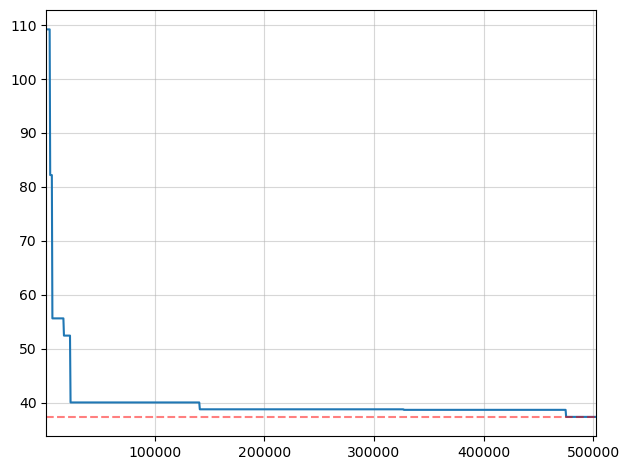

In [73]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [51]:
num_runs = 20
alg_name = 'SCA'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = sine_cosine_algorithm(min_val, max_val, num_variables, pop_size, a, iteration, obj_func)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i

Run 1 Done in 48.72 s; OF: 36.9163


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3992719888.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

Run 2 Done in 48.60 s; OF: 37.5690


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 3 Done in 48.34 s; OF: 37.4449


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 4 Done in 48.94 s; OF: 37.0919


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3992719888.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: inv

Run 5 Done in 48.52 s; OF: 37.0191


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3992719888.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

Run 6 Done in 48.38 s; OF: 37.8677


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3992719888.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

Run 7 Done in 48.74 s; OF: 36.8983


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 8 Done in 48.53 s; OF: 36.8097


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3992719888.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: inv

Run 9 Done in 48.36 s; OF: 38.1962


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 10 Done in 48.43 s; OF: 38.5048


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3992719888.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506

Run 11 Done in 48.69 s; OF: 36.7751


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 12 Done in 48.47 s; OF: 36.8450


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 13 Done in 48.55 s; OF: 37.7252


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3992719888.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506

Run 14 Done in 48.53 s; OF: 37.3232


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 15 Done in 50.16 s; OF: 37.3180


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 16 Done in 48.65 s; OF: 36.8890


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 17 Done in 48.53 s; OF: 37.0910


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 18 Done in 48.71 s; OF: 39.3451


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 19 Done in 48.56 s; OF: 38.4006


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m


Run 20 Done in 48.37 s; OF: 37.5846


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3992719888.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### XIII. Firefly Algorithm (FA)

In [52]:
def init_generator(pop_size, num_variables, min_val, max_val):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def distance(x, y):
    return np.sqrt(np.sum((x-y)**2))

def attractivness(dist_val, beta_0, gamma, m):
    return beta_0*np.exp(-gamma*dist_val**m)

def evaluate(a, b, obj_func):
    of_a =obj_func(a)
    of_b = obj_func(b)
    if np.isnan(of_a):#to deal with nan values
        of_a = np.inf
    if np.isnan(of_b):#to deal with nan values
        of_b = np.inf
    if obj_func(a)<obj_func(b):
        return True
    else:
        return False
        
def improve_position(a, b, obj_func, beta_0, gamma, m):
    if evaluate(b, a, obj_func):
        dist_val = distance(a, b)
        rand_value = np.random.normal()*(np.random.uniform()-.5)
        return a + attractivness(dist_val, beta_0, gamma, m)*(b-a) + rand_value
    else:
        return a
    
def sorting_pop(pop, obj_func):
    results = np.apply_along_axis(obj_func, 1, pop)
    results = np.nan_to_num(results, nan=np.inf) #to deal with nan values
    indeces = np.argsort(results)
    return pop[indeces]

def firefly_algorithm(pop_size, num_variables, min_val, max_val, beta_0, gamma, m, iteration, obj_func):
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    NFE_value = 0
    pop = init_generator(pop_size, num_variables, min_val, max_val)
    pop = sorting_pop(pop, obj_func)
    NFE_value += pop_size
    for k in range(iteration):
        for i in range(pop_size):
            for j in range(pop_size):
                pop [i] = improve_position(pop[i], pop[j], obj_func, beta_0, gamma, m)
            NFE_value += pop_size
        pop = sorting_pop(pop, obj_func)
        NFE[k] = NFE_value
        results[k] = obj_func(pop[0])
    return pop[0], obj_func(pop[0]), results, NFE

In [53]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [54]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 75
iteration = 200
beta_0 = 1
gamma = .1
m = 2

In [226]:
start_time = time.time()

X, best_of, results, NFE = firefly_algorithm(pop_size, num_variables, min_val,
                                             max_val, beta_0, gamma, m, iteration, obj_func)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
Best OF ====================
183.14799310522676
Variables ==================
[0.80724918 0.24007025 1.38096255]
Time ======================
Time: 2 min and 28.39 s


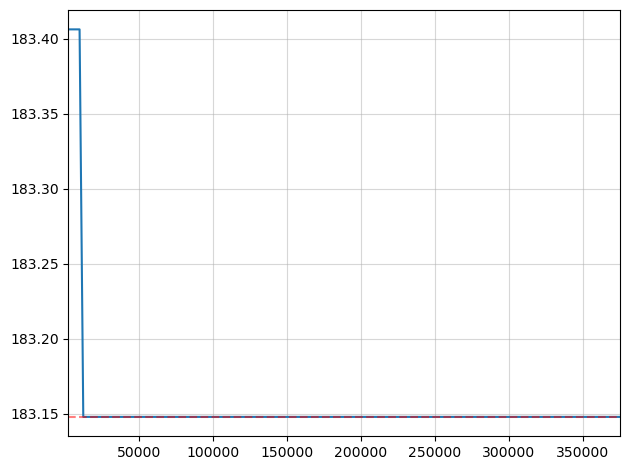

In [227]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [55]:
num_runs = 20
alg_name = 'FA'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = firefly_algorithm(pop_size, num_variables, min_val,
                                                 max_val, beta_0, gamma, m, iteration, obj_func)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(

Run 1 Done in 442.15 s; OF: 86.2661


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 2 Done in 442.25 s; OF: 42.1241


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 3 Done in 444.56 s; OF: 73.5116


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 4 Done in 444.84 s; OF: 240.9759


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 5 Done in 443.74 s; OF: 197.5144


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 6 Done in 443.40 s; OF: 114.2328


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 7 Done in 443.84 s; OF: 153.0628


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 8 Done in 443.81 s; OF: 157.6483


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 9 Done in 441.94 s; OF: 98.8179


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 10 Done in 442.55 s; OF: 114.6778


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 11 Done in 442.43 s; OF: 118.9458


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 12 Done in 442.59 s; OF: 158.8050


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 13 Done in 442.03 s; OF: 50.6817


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 14 Done in 439.56 s; OF: 137.3745


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 15 Done in 442.87 s; OF: 128.0145


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 16 Done in 443.80 s; OF: 106.9858


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 17 Done in 444.68 s; OF: 157.5179


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 18 Done in 449.47 s; OF: 70.7246


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 19 Done in 443.74 s; OF: 68.4452
Run 20 Done in 442.39 s; OF: 162.7712


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3299295131.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### XIV. Flower Pollination Algorithm (FPA)

In [56]:
def init_genrator(min_val, max_val, pop_size, num_variables):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def levy_flight(pop_size, beta):
    sigma_v = 1
    sigma_u = ((special.gamma(beta+1)*np.sin(np.pi*beta*.5))/(special.gamma((1+beta)*.5)*beta*2**((beta-1)*.5)))**(1/beta)
    v = np.random.normal(0,sigma_v,size=pop_size)
    u = np.random.normal(0,sigma_u,size=pop_size)
    s = u/(np.abs(v)**(1/beta))
    return s.reshape(-1,1)

def best_solution(pop, obj_func):
    results = np.apply_along_axis(obj_func, 1, pop)
    results = np.nan_to_num(results, nan=np.inf) #to deal with nan values
    index = np.argmin(results)
    return pop[index]

def global_pollination(pop, pop_size, xbest, beta):
    L = levy_flight(pop_size, beta)
    return pop + L*(pop-xbest)

def local_pollination(pop, pop_size):
    index_1 = np.random.choice(np.arange(pop_size),size=pop_size,replace=False)
    index_2 = np.random.choice(np.arange(pop_size),size=pop_size,replace=False)
    pop_1 = pop[index_1]
    pop_2 = pop[index_2]
    rand = np.random.uniform(0,1,size=(pop_size,1))
    return pop + rand*(pop_1-pop_2)

def merge(pop, pop_new, obj_func):
    of = np.apply_along_axis(obj_func, 1, pop)
    of = np.nan_to_num(of, nan=np.inf) #to deal with nan values
    of_new = np.apply_along_axis(obj_func, 1, pop_new)
    of_new = np.nan_to_num(of_new, nan=np.inf) #to deal with nan values
    indeces = (of<of_new).reshape(-1,1)
    return np.where(indeces, pop, pop_new)

def flower_pollination_algorithm(min_val, max_val, num_variables, pop_size, beta,
                                 switch_prob, iteration, obj_func):
    NFE_value = 0
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    pop = init_genrator(min_val, max_val, pop_size, num_variables)
    xbest = best_solution(pop, obj_func)
    for i in range(iteration):
        rand = np.random.uniform()
        if rand<switch_prob:
            pop_new = global_pollination(pop, pop_size, xbest, beta)
        else:
            pop_new = local_pollination(pop, pop_size)
        pop = merge(pop, pop_new, obj_func)
        xbest = best_solution(pop, obj_func)
        NFE_value += 4*pop_size
        results[i] = obj_func(xbest)
        NFE[i] = NFE_value
    return xbest, obj_func(xbest), results, NFE

In [57]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [58]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 500
iteration = 1000
beta = 1.5
switch_prob = .8

In [100]:
start_time = time.time()

X, best_of, results, NFE = flower_pollination_algorithm(min_val, max_val, num_variables, pop_size, beta,
                                                        switch_prob, iteration, obj_func)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


0
10


C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S


20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)


200
210
220
230
240
250
260
270
280
290
300
310
320


C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m


330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Best OF ====================
36.767888456425574
Variables ==================
[0.0862491  0.28691659 1.86808711]
Time ======================
Time: 2 min and 25.33 s


In [ ]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [59]:
num_runs = 20
alg_name = 'FPA'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'


overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = flower_pollination_algorithm(min_val, max_val, num_variables, pop_size, beta,
                                                            switch_prob, iteration, obj_func)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\L

Run 1 Done in 142.14 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid valu

Run 2 Done in 148.56 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars


Run 3 Done in 142.55 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'

Run 4 Done in 142.80 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid valu

Run 5 Done in 142.71 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid valu

Run 6 Done in 142.60 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'

Run 7 Done in 142.56 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykerne

Run 8 Done in 142.29 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'

Run 9 Done in 142.39 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'

Run 10 Done in 142.31 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykerne

Run 11 Done in 142.54 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 12 Done in 142.37 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykerne

Run 13 Done in 142.60 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid valu

Run 14 Done in 142.34 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 15 Done in 142.85 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'

Run 16 Done in 142.24 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid valu

Run 17 Done in 142.47 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'

Run 18 Done in 141.50 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'

Run 19 Done in 142.25 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: Ru

Run 20 Done in 142.45 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\507292967.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### XV. Gravity Search Algorithm (GSA)

In [60]:
def init_generator(pop_size, num_variabels, min_val, max_val):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def sorting_pop(pop, obj_func):
    results = np.apply_along_axis(obj_func, 1, pop)
    results = np.nan_to_num(results, nan=10e6) #to deal with nan values
    indeces = np.argsort(results)
    return pop[indeces]

def normalizing_ofs(sorted_pop):
    results = np.apply_along_axis(obj_func, 1, sorted_pop)
    results = np.nan_to_num(results, nan=10e6) #to deal with nan values
    best = results[0]
    worst = results[-1]
    return (results-worst)/(best-worst)

def particles_mass(sorted_pop):
    normalized_results = normalizing_ofs(sorted_pop)
    sum_values = np.sum(normalized_results)
    return normalized_results/sum_values

def distance(a, b):
    return np.sqrt(np.sum((a-b)**2))

def force(a, b, sorted_pop, mass_values, gamma, epsilon=1e-3):
    dist_val = distance(sorted_pop[a], sorted_pop[b])
    return gamma*mass_values[a]*mass_values[b]*(sorted_pop[b]-sorted_pop[a])/(dist_val+epsilon)

def active_agents(iteration, agents_0, agents_last):
    agents = agents_0-(np.arange(iteration)*(agents_0-agents_last)/iteration)
    return agents.astype(int)

def acceleration(sorted_pop, pop_size, num_variables, mass_values, gamma, min_val, 
                 max_val, agents_0, agents_last, epsilon=1e-3):
    acceleration_values = np.zeros_like(sorted_pop)
    agents = active_agents(iteration, agents_0, agents_last)
    for i in range(pop_size):
        a = np.zeros((1, num_variables))
        for j in range(agents[i]):
            rand_value = np.random.uniform()
            a += (rand_value*force(i, j, sorted_pop, mass_values, gamma, epsilon))
        if mass_values[i]!=0:
            acceleration_values[i] = (a)/mass_values[i]
        else:
            acceleration_values[i] = np.random.uniform(min_val, max_val, (1, num_variables))
    return acceleration_values

def gamma_values(gamma_0, alpha, iteration):
    x = np.arange(iteration)
    return gamma_0*np.exp(-alpha*x/iteration)

def gravity_search_algorithm(num_variables, pop_size, min_val, max_val, gamma_0, alpha,
                            iteration, obj_func, epsilon=1e-3):
    NFE_value = 0
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    pop = init_generator(pop_size, num_variables, min_val, max_val)
    pop = sorting_pop(pop, obj_func)
    gbest = pop[0]
    of_gbest = obj_func(gbest)
    NFE_value += pop_size
    gamma = gamma_values(gamma_0, alpha, iteration)
    velocity = np.zeros_like(pop)
    for k in range(iteration):
        mass_values = particles_mass(pop)
        acceleration_values = acceleration(pop, pop_size, num_variables, mass_values, 
                                           gamma[k], min_val, max_val, agents_0, agents_last, epsilon)
        velocity = np.random.uniform()*velocity+acceleration_values
        pop += velocity
        pop = sorting_pop(pop, obj_func)
        of_test = obj_func(pop[0])
        if of_test<= of_gbest:
                gbest = pop[0]
                of_gbest = obj_func(gbest)
        NFE_value += pop_size
        results[k] = of_gbest
        NFE[k] = NFE_value
    return gbest, of_gbest, results, NFE

In [61]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [62]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 500 
iteration = 1000
gamma_0 = 500
agents_0, agents_last = 10, 5
alpha = 20

In [113]:
start_time = time.time()

X, best_of, results, NFE = gravity_search_algorithm(num_variables, pop_size, min_val, max_val,
                                                    gamma_0, alpha, iteration, obj_func)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)


0


C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Best OF ====================
36.767888456425595
Variables ==================
[0.0862491  0.2869166  1.86808711]
Time ======================
Time: 2 min and 27.22 s


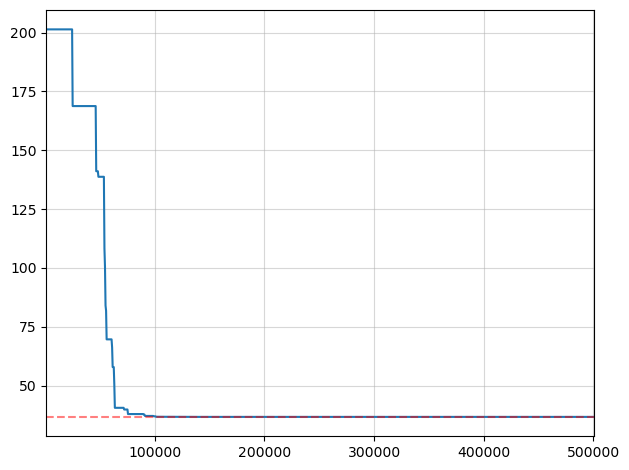

In [114]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [63]:
num_runs = 20
alg_name = 'GSA'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = gravity_search_algorithm(num_variables, pop_size, min_val, max_val,
                                                        gamma_0, alpha, iteration, obj_func)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed fro

Run 1 Done in 147.73 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 2 Done in 147.30 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 3 Done in 147.78 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeW

Run 4 Done in 146.69 s; OF: 95.0879


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 5 Done in 148.12 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 6 Done in 152.26 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_resu

Run 7 Done in 147.77 s; OF: 117.4171


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 8 Done in 147.48 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeW

Run 9 Done in 146.12 s; OF: 152.9604


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(

Run 10 Done in 147.81 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 11 Done in 148.57 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 12 Done in 149.74 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 13 Done in 147.18 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 14 Done in 147.08 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 15 Done in 147.41 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 16 Done in 146.87 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 17 Done in 147.58 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 18 Done in 146.55 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(

Run 19 Done in 147.98 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)


Run 20 Done in 147.81 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2315875756.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### XVI. Invasive Weed Optimization (IWO)

In [64]:
def init_generator(num_variables, pop_size, min_val, max_val):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def sorting_pop(pop, obj_func):
    results = np.apply_along_axis(func1d=obj_func, axis=1, arr=pop)
    results = np.nan_to_num(results, nan=10e6) #to deal with nan values
    indeces = np.argsort(results)
    return pop[indeces]    

def seed_counts(sorted_pop, max_seed, min_seed, obj_func):
    results = np.apply_along_axis(func1d=obj_func, axis=1, arr=sorted_pop)
    results = np.nan_to_num(results, nan=10e6) #to deal with nan values
    best, worst = results[0], results[-1]
    values = ((max_seed-min_seed)/np.abs(best-worst))*np.abs(results-worst)
    values = np.round(values, 0)
    values[0], values[-1] = max_seed, min_seed
    values = values.astype(int)
    return values

def std_generator(std_init, std_final, beta, iteration):
    values = np.arange(iteration)
    return ((iteration-values)**beta/iteration**beta)*(std_init-std_final) + std_final

def pop_control(sorted_pop, max_pop):
    if len(sorted_pop)>max_pop:
        return sorted_pop[:max_pop]
    else:
        return sorted_pop
    
def new_weed_generator(x, num_variables, seed_value, std):
    return np.random.normal(loc=0, scale=std, size=(seed_value, num_variables)) + x

def invasive_weed_optimization(min_val, max_val, num_variables, iteration, pop_size, obj_func,
                               max_seed, min_seed, std_init, std_final, beta, max_pop):
    NFE_value = 0
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    pop = init_generator(num_variables, pop_size, min_val, max_val)
    NFE_value += pop_size
    pop = sorting_pop(pop, obj_func)
    std_values = std_generator(std_init, std_final, beta, iteration)
    for i in range(iteration):
        seed_values = seed_counts(pop, max_seed, min_seed, obj_func)
        NFE_value += np.sum(seed_values)
        std = std_values[i]
        for j in range(len(seed_values)):
            new_weeds = new_weed_generator(pop[j], num_variables, seed_values[j], std)
            pop = np.concatenate((pop, new_weeds), axis = 0)
        pop = sorting_pop(pop, obj_func)
        pop = pop_control(pop, max_pop)
        results[i] = obj_func(pop[0])
        NFE[i] = NFE_value

    return pop[0], obj_func(pop[0]), results, NFE

In [65]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [66]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 750
iteration = 1500
max_seed, min_seed = 10, 5
std_init, std_final = 2, .5
beta = 1
max_pop = pop_size

In [118]:
start_time = time.time()

X, best_of, results, NFE = invasive_weed_optimization(min_val, max_val, num_variables, iteration, pop_size, obj_func,
                                                      max_seed, min_seed, std_init, std_final, beta, max_pop)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Best OF ====================
49.43006043778705
Variables ==================
[0.07346235 0.28782577 1.89683102]
Time ======================
Time: 3 min and 13.62 s


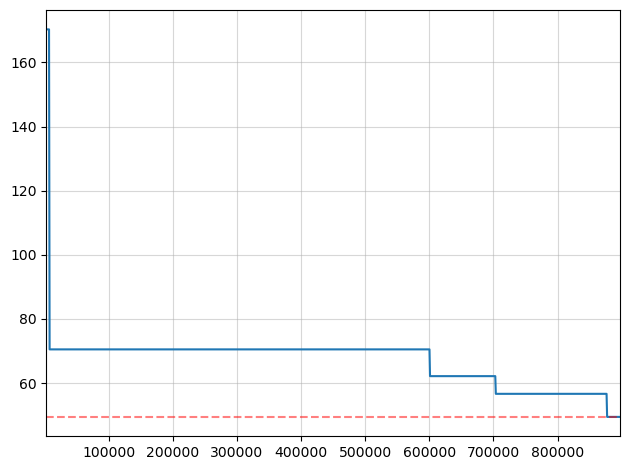

In [119]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [67]:
num_runs = 20
alg_name = 'IWO'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = invasive_weed_optimization(min_val, max_val, num_variables, iteration, pop_size, obj_func,
                                                          max_seed, min_seed, std_init, std_final, beta, max_pop)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from

Run 1 Done in 410.20 s; OF: 42.0466


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 2 Done in 406.56 s; OF: 44.5796


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 3 Done in 406.41 s; OF: 38.0154


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 4 Done in 413.12 s; OF: 37.9640


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 5 Done in 415.82 s; OF: 46.5744


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 6 Done in 410.14 s; OF: 47.6046


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 7 Done in 406.23 s; OF: 37.3021


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 8 Done in 411.81 s; OF: 45.9208


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 9 Done in 407.51 s; OF: 39.6692


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 10 Done in 408.34 s; OF: 39.2963


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 11 Done in 406.08 s; OF: 37.4832


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 12 Done in 405.87 s; OF: 39.2154


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 13 Done in 425.33 s; OF: 37.0691


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 14 Done in 414.40 s; OF: 44.1170


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 15 Done in 433.00 s; OF: 47.4198


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 16 Done in 419.16 s; OF: 39.2646


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1

Run 17 Done in 421.27 s; OF: 37.3150


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1

Run 18 Done in 408.33 s; OF: 41.0323


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Loc

Run 19 Done in 412.54 s; OF: 42.3050


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 20 Done in 410.60 s; OF: 38.8254


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\831776445.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### XVII. Symbiotic Organisms Search (SOS)

In [68]:
def init_generator(pop_size, num_variables, min_val, max_val):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def best_solution(pop, obj_func):
    results = np.apply_along_axis(obj_func, 1, pop)
    results = np.nan_to_num(results, nan=np.inf) #to deal with nan values
    index = np.argmin(results)
    return pop[index]

def mutualism(a, b, xbest, num_variables):
    mutual_factor = np.mean((a, b), axis=0)
    beta1, beta2 = np.random.randint(1,3, 2)
    rand1, rand2 = np.random.uniform(0,1,(2,num_variables))
    a_new = a + rand1*(xbest - (mutual_factor*beta1))
    b_new = b + rand2*(xbest - (mutual_factor*beta2))
    return a_new, b_new

def commensalism(a, b, xbest, num_variables):
    rand = np.random.uniform(0, 1, num_variables)
    a_new = a + rand*(xbest-b)
    return a_new

def parasitism(a, min_val, max_val, num_variables):
    parasite = a.copy()
    index = np.random.randint(num_variables)
    rand = np.random.uniform(min_val, max_val)
    parasite[index] = rand[index] #this is beacuse it min and max are list
    return parasite

def evaluator(a, b, obj_func):
    of_a = obj_func(a)
    of_b = obj_func(b)
    if np.isnan(of_a):
        of_a = np.inf
    if np.isnan(of_b):
        of_b = np.inf
    if of_a<of_b:
        return a
    else:
        return b
        
def symbiotic_organisms_search(min_val, max_val, num_variables, pop_size, obj_func, iteration):
    NFE_value = 0
    results = np.zeros(iteration)
    NFE = np.zeros(iteration)
    pop = init_generator(pop_size, num_variables, min_val, max_val)
    NFE_value += pop_size
    for i in range(iteration):
        xbest = best_solution(pop, obj_func)
        for j in range(pop_size):
            r = np.random.randint(pop_size)
            organ1, organ2 = mutualism(pop[j], pop[r], xbest, num_variables)
            pop[j] = evaluator(pop[j], organ1, obj_func)
            pop[r] = evaluator(pop[r], organ1, obj_func)
            r = np.random.randint(pop_size)
            oragan1 = commensalism(pop[j], pop[r], xbest, num_variables)
            pop[j] = evaluator(pop[j], organ1, obj_func)
            parasite = parasitism(pop[j], min_val, max_val, num_variables)
            r = np.random.randint(pop_size)
            pop[r] = evaluator(pop[r], parasite, obj_func)
            NFE_value+=4
        NFE[i] = NFE_value
        results[i] = obj_func(best_solution(pop, obj_func))

    return best_solution(pop, obj_func), obj_func(best_solution(pop, obj_func)), results, NFE

In [69]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [70]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 500
iteration = 1000

In [123]:
start_time = time.time()

X, best_of, results, NFE = symbiotic_organisms_search(min_val, max_val, num_variables, pop_size, obj_func, iteration)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


0


C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Best OF ====================
36.767888456425545
Variables ==================
[0.0862491  0.2869166  1.86808711]
Time ======================
Time: 8 min and 54.81 s


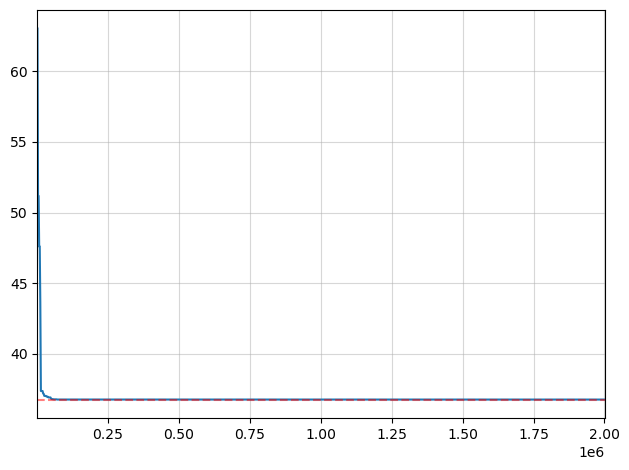

In [124]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [71]:
num_runs = 20
alg_name = 'SOS'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = symbiotic_organisms_search(min_val, max_val, num_variables, pop_size, obj_func, iteration)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed fro

Run 1 Done in 518.27 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 2 Done in 517.53 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 3 Done in 517.64 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(

Run 4 Done in 536.16 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 5 Done in 560.65 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(

Run 6 Done in 556.81 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 7 Done in 556.70 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 8 Done in 554.91 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(

Run 9 Done in 561.67 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 10 Done in 555.39 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 11 Done in 560.17 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 12 Done in 558.98 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 13 Done in 567.54 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 14 Done in 569.20 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 15 Done in 567.56 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 16 Done in 562.80 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 17 Done in 557.23 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 18 Done in 560.51 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 19 Done in 556.77 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)


Run 20 Done in 560.95 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3808840816.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### XVIII. Cuckoo Search (CS) Algorithm

In [74]:
def init_generator(pop_size, num_variables, min_val, max_val):
    return np.random.uniform(min_val, max_val, size=(pop_size, num_variables))

def levy_flight(x, beta, step_size):
    sigma_v = 1
    sigma_u = ((special.gamma(beta+1)*np.sin(np.pi*beta*.5))/(special.gamma((1+beta)*.5)*beta*2**((beta-1)*.5)))**(1/beta)
    v = np.random.normal(0,sigma_v,size=x.shape)
    u = np.random.normal(0,sigma_u,size=x.shape)
    s = u/(np.abs(v)**(1/beta))
    return x + step_size*s

def sorting_pop(pop, obj_func):
    results = np.apply_along_axis(obj_func, 1, pop)
    results = np.nan_to_num(results, nan=np.inf) #to deal with nan values
    indeces = np.argsort(results)
    return pop[indeces]

def evaluate(a, b, obj_func):
    if obj_func(b)<obj_func(a):
        return True
    else:
        return False      
        
def cuckoo_search_algorithm(pop_size, num_variables, min_val, max_val, step_size, beta,
                            prob_a, obj_func, iteration):
    NFE = np.zeros(iteration)
    NFE_value = 0
    results = np.zeros(iteration)
    pop = init_generator(pop_size, num_variables, min_val, max_val)
    pop = sorting_pop(pop, obj_func)
    for i in range(iteration):
        for j in range(pop_size):
            m, n = np.random.randint(1, pop_size, 2)
            new_cuckoo = levy_flight(pop[m], beta, step_size)
            if evaluate(pop[n], new_cuckoo, obj_func):
                pop[n] = new_cuckoo
                pop = sorting_pop(pop, obj_func)
            rand = np.random.uniform()
            if rand<prob_a:
                pop[-1] = levy_flight(pop[-1], beta, step_size)
                pop = sorting_pop(pop, obj_func)
            NFE_value += 2
        NFE[i] = NFE_value
        results[i] = obj_func(pop[0])
    return pop[0], obj_func(pop[0]), results, NFE

In [75]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [76]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 100#500
iteration = 2000#1000
step_size = 1
beta = 1.5
prob_a = .25

In [159]:
start_time = time.time()

X, best_of, results, NFE = cuckoo_search_algorithm(pop_size, num_variables, min_val, max_val, step_size, beta,
                                                   prob_a, obj_func, iteration)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


0
10
20
30
40
50
60
70
80
90


C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S


100
110
120
130
140
150


C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


160
170
180
190
200
210
220
230
240


C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)


250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
Best OF ====================
120.44495296368365
Variables ==================
[0.17818492 0.24191136 1.69274951]
Time ======================
Time: 0 min and 30.84 s


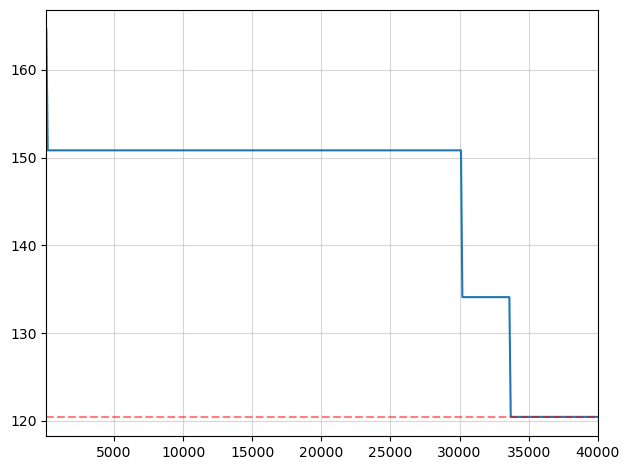

In [160]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [77]:
num_runs = 20
alg_name = 'CA'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = cuckoo_search_algorithm(pop_size, num_variables, min_val, max_val, step_size, beta,
                                                       prob_a, obj_func, iteration)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S =

Run 1 Done in 549.66 s; OF: 46.7020


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 2 Done in 569.58 s; OF: 120.7407


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 3 Done in 559.13 s; OF: 71.2221


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 4 Done in 566.43 s; OF: 54.9014


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 5 Done in 570.82 s; OF: 50.8981


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 6 Done in 556.39 s; OF: 53.9767


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\

Run 7 Done in 552.61 s; OF: 78.1293


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 8 Done in 549.00 s; OF: 70.6652


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 9 Done in 573.78 s; OF: 42.4968


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 10 Done in 571.03 s; OF: 46.6220


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in double_scalars
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Lo

Run 11 Done in 585.94 s; OF: 38.7764


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 12 Done in 617.29 s; OF: 39.2923


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 13 Done in 599.60 s; OF: 59.8776


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\

Run 14 Done in 639.63 s; OF: 64.7750


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 15 Done in 653.75 s; OF: 37.8250


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 16 Done in 602.69 s; OF: 49.8066


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\

Run 17 Done in 624.90 s; OF: 87.5016


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 18 Done in 608.73 s; OF: 42.2807


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\

Run 19 Done in 610.31 s; OF: 45.3550


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:4: RuntimeWarning: overflow encountered in power
  S[0] = K*I[0]**m
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:8: RuntimeWarning: invalid value encountered in double_scalars
  S[i+1] = S[i] + change_rate_S


Run 20 Done in 602.54 s; OF: 56.5058


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3558263309.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### XIX. Shuffled Frog‐Leaping Algorithm (SFLA)

In [78]:
def init_generator(num_variables, pop_size, min_val, max_val):
    return np.random.uniform(low=min_val,high=max_val,size=(pop_size, num_variables))

def sorting_pop(pop, obj_func):
    ofs = np.apply_along_axis(func1d=obj_func, axis=1, arr=pop)
    ofs = np.nan_to_num(ofs, nan=np.inf) #to deal with nan values
    indeces = np.argsort(ofs)
    return pop[indeces]

def creating_memeplexes(pop_size, num_memeplex):
    memeplexes=list()
    for i in range(num_memeplex):
        temp=list(range(i,pop_size,num_memeplex))
        memeplexes.append(temp)
    return memeplexes

def creating_submemeplex(memeplex, size_memeplex, size_submemeplex):
    Y = np.arange(size_memeplex)
    prob = 2*(1+size_memeplex-Y)/(size_memeplex*(size_memeplex+1))
    const = (1-np.sum(prob))/size_memeplex
    prob += const
    sub_index = np.random.choice(np.arange(size_memeplex), size_submemeplex, replace=False, p=prob)
    return memeplex[sub_index]

def compare(a, b , obj_func):
    if obj_func(a)<obj_func(b):
        return True
    else:
        return False


def adjust_movement(x, dmin, dmax):
    x = np.where(x<dmin, dmin, x)
    x = np.where(x>dmax, dmax, x)
    return x

def shuffled_frog_leaping_algorithm(num_memeplex, size_memeplex, num_variables,min_val, max_val,
                                    iteration, obj_func, num_memetic_evelution, dmin=-np.inf, dmax=np.inf):
    NFE_value = 0
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    pop_size = num_memeplex*size_memeplex
    pop = init_generator(num_variables, pop_size, min_val, max_val)
    pop = sorting_pop(pop, obj_func)
    NFE_value += pop_size
    for i in range(iteration):
        pbest=pop[0]
        memeplexes_indeces = creating_memeplexes(pop_size, num_memeplex)
        for memeplexes_index in memeplexes_indeces:
            memeplex = pop[memeplexes_index]
            for j in range(num_memetic_evelution):
                sub_memeplex = creating_submemeplex(memeplex, size_memeplex, size_submemeplex)
                sub_memeplex = sorting_pop(sub_memeplex, obj_func)
                mbest = sub_memeplex[0]
                mworst = sub_memeplex[-1]
                rand = np.random.uniform(0,1, num_variables)
                move_1 = rand*(mbest-mworst)
                move_1 = adjust_movement(move_1, dmin, dmax)
                temp_point_1 = mworst+move_1
                move_2 = rand*(pbest-mworst)
                move_2 = adjust_movement(move_2, dmin, dmax)
                temp_point_2 = mworst+move_2
                if compare(temp_point_1, mworst, obj_func):
                    new_x=temp_point_1
                    NFE_value += 1
                elif compare(temp_point_2, mworst, obj_func):
                    new_x=temp_point_2
                    NFE_value += 1
                else:
                    new_x=np.random.uniform(min_val, max_val, num_variables)
                    NFE_value += 1
                pop = np.concatenate((pop, np.reshape(new_x, (1,-1))), axis=0)
        pop = sorting_pop(pop, obj_func)[:pop_size]
        NFE[i] = NFE_value
        results[i] = obj_func(pop[0])
    return pop[0], obj_func(pop[0]), results, NFE

In [79]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [80]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

num_memeplex = 10
size_memeplex = 75
size_submemeplex = 3
num_memetic_evelution = 10
iteration = 1500

In [172]:
start_time = time.time()

X, best_of, results, NFE = shuffled_frog_leaping_algorithm(num_memeplex, size_memeplex, num_variables,min_val, max_val,
                                                           iteration, obj_func, num_memetic_evelution)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Best OF ====================
49.111440895222216
Variables ==================
[0.17384551 0.2875813  1.71329719]
Time ======================
Time: 2 min and 8.11 s


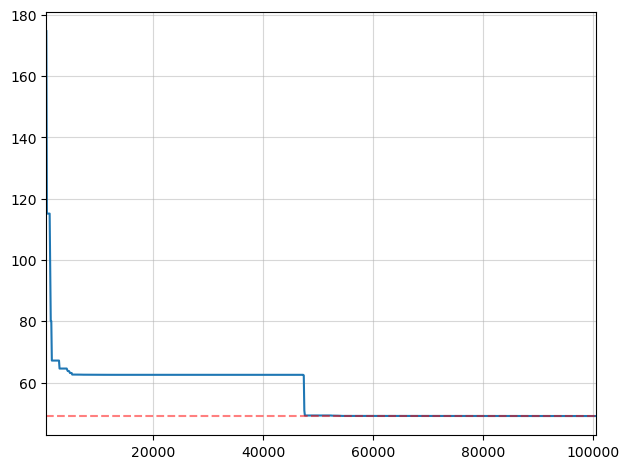

In [173]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [81]:
num_runs = 20
alg_name = 'SFAL'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = shuffled_frog_leaping_algorithm(num_memeplex, size_memeplex, num_variables,min_val, max_val,
                                                               iteration, obj_func, num_memetic_evelution)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(

Run 1 Done in 289.24 s; OF: 36.8036


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 2 Done in 279.47 s; OF: 40.5289


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 3 Done in 287.52 s; OF: 40.3248


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 4 Done in 288.89 s; OF: 38.9674


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 5 Done in 248.42 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 6 Done in 238.97 s; OF: 38.3828


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 7 Done in 258.34 s; OF: 39.3693


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 8 Done in 286.32 s; OF: 36.9994


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 9 Done in 242.77 s; OF: 36.7680


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 10 Done in 268.86 s; OF: 36.8850


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 11 Done in 291.14 s; OF: 37.3508


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 12 Done in 279.45 s; OF: 36.8371


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 13 Done in 283.78 s; OF: 36.9282


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 14 Done in 271.74 s; OF: 37.5144


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 15 Done in 268.35 s; OF: 42.3918


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 16 Done in 256.49 s; OF: 40.2592


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 17 Done in 290.67 s; OF: 36.7683


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 18 Done in 295.38 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 19 Done in 287.23 s; OF: 37.0698
Run 20 Done in 310.26 s; OF: 36.7826


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\3613650674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### XX. STML

In [82]:
def boundery_checker(pop, min_val, max_val):
    adj_pop = np.where(pop<min_val, min_val, pop)
    adj_pop = np.where(adj_pop>max_val, max_val, adj_pop)
    return adj_pop

def init_genrator_tlbo(min_val, max_val, num_variables, pop_size):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def sorting_pop(pop, obj_func):
    results = np.apply_along_axis(obj_func, 1, pop)
    results = np.nan_to_num(results, nan=np.inf) #to deal with nan values
    indeces = np.argsort(results)
    return pop[indeces]

def teacher_phase(pop, pop_size, obj_func, min_val, max_val):
    teacher = pop[0]
    center = np.mean(pop, axis=0)
    rand = np.random.uniform(0,1,size=(pop_size,1))
    teacher_factor = np.random.choice(np.arange(1,3), size=(pop_size,1))
    diff = rand*(teacher-center*teacher_factor)
    pop_new = pop + diff
    pop_new = boundery_checker(pop_new, min_val, max_val)
    results = np.apply_along_axis(obj_func, 1, pop)
    results = np.nan_to_num(results, nan=np.inf) #to deal with nan values
    results_new = np.apply_along_axis(obj_func, 1, pop_new)
    results_new = np.nan_to_num(results_new, nan=np.inf) #to deal with nan values
    return np.where((results_new<results).reshape(-1,1), pop_new, pop)

def learner_phase(pop, pop_size, obj_func, min_val, max_val):
    rand = np.random.uniform(0,1,size=(pop_size,1))
    pop_new = np.zeros_like(pop)
    for i in range(pop_size):
        x, y = np.sort(np.random.choice(np.arange(pop_size), size=2, replace=False))
        pop_new[i] = pop[i] + rand[i]*(pop[x]-pop[y])
    pop_new = boundery_checker(pop_new, min_val, max_val)
    pop_overall = np.concatenate((pop, pop_new), axis=0)
    pop_overall = sorting_pop(pop_overall, obj_func)
    return pop_overall[:pop_size]

def tlbo(pop_size, iteration, min_val, max_val, num_variables, obj_func):
    NFE_value = 0
    pop = init_genrator_tlbo(min_val, max_val, num_variables, pop_size)
    pop = sorting_pop(pop, obj_func)
    for i in range(iteration):
        pop = teacher_phase(pop, pop_size, obj_func, min_val, max_val)
        pop = sorting_pop(pop, obj_func)
        pop = learner_phase(pop, pop_size, obj_func, min_val, max_val)
        NFE_value += (3*pop_size)
    return pop[0], obj_func(pop[0]), NFE_value

def init_generator(pop_size_min, pop_size_max, iteration_min, iteration_max):
    return np.random.uniform(np.array([pop_size_min,iteration_min]),np.array([pop_size_max,iteration_max]),size=2).astype(int)

def exploratory_move(X, mu, NFE_value, min_val, max_val, num_variables, obj_func):
    mesh = (mu*np.eye(len(X)) + X).astype(int)
    sim_results = np.zeros(shape=(len(mesh), num_variables))
    eval_results = np.zeros(len(mesh))
    for index in range(len(mesh)):
        array, of_best, NFE = tlbo(mesh[index][0], mesh[index][1], min_val, max_val, num_variables, obj_func)
        sim_results[index] = array
        eval_results[index] = of_best
        NFE_value += NFE
    return mesh, eval_results, sim_results, NFE_value  

def pattern_move(current_base, previous_base, NFE_value, min_val, max_val, num_variables, obj_func, alpha,
                 pop_size_min, pop_size_max, iteration_min, iteration_max):
    current_base, previous_base = np.array(current_base), np.array(previous_base) #????
    X_new = previous_base + alpha*(current_base-previous_base)
    sim_result, of_new, NFE = tlbo(X_new[0], X_new[1], min_val, max_val, num_variables, obj_func)
    NFE_value += NFE
    return X_new.astype(int), sim_result, of_new, NFE_value

def mega_algorithem(obj_func, min_val, max_val, num_variables, 
                    pop_size_min, pop_size_max, iteration_min, iteration_max,
                    mu_const=5, alpha=2, delta=1, final_step_size=1):
    num_s_patt = 0
    num_s_explore = 0
    results_list = list()
    NFE_list = list()
    hypr_list = list()
    NFE_value = 0
    X = init_generator(pop_size_min, pop_size_max, iteration_min, iteration_max)
    setting, best_of, NFE = tlbo(X[0], X[1], min_val, max_val, num_variables, obj_func)
    NFE_value += NFE
    mu = mu_const
    hypr_list.append(X)
    results_list.append(best_of)
    NFE_list.append(NFE_value)
    while mu > final_step_size:
        mesh, eval_results, new_settings, NFE_value = exploratory_move(X, mu, NFE_value, min_val, max_val,
                                                                       num_variables, obj_func)
        if np.min(eval_results) < best_of:
            num_s_explore += 1
            mu = mu_const
            best_of = np.array([np.min(eval_results)])
            current_base = mesh[np.argmin(eval_results)]
            previous_base = X
            setting = new_settings[np.argmin(eval_results)]
            hypr_list.append(current_base)
            results_list.append(best_of)
            NFE_list.append(NFE_value)
            while True:
                X_new, sim_result, of_new, NFE_value = pattern_move(current_base, previous_base, NFE_value,min_val,
                                                                    max_val, num_variables, obj_func, alpha,
                                                                    pop_size_min, pop_size_max, iteration_min,
                                                                    iteration_max)
                if of_new < best_of:
                    num_s_patt += 1
                    previous_base = current_base
                    current_base, best_of = X_new, of_new
                    setting = sim_result
                    hypr_list.append(current_base)
                    results_list.append(best_of)
                    NFE_list.append(NFE_value)
                    mesh, eval_results, new_settings, NFE_value = exploratory_move(current_base, mu, NFE_value, min_val,
                                                                                   max_val, num_variables, obj_func)
                    if np.min(eval_results) < best_of:
                        num_s_explore += 1
                        best_of = np.array([np.min(eval_results)])
                        previous_base = current_base
                        current_base = mesh[np.argmin(eval_results)]
                        setting = new_settings[np.argmin(eval_results)]
                        hypr_list.append(current_base)
                        results_list.append(best_of)
                        NFE_list.append(NFE_value)
                else:
                    mu -= delta
                    X = current_base
                    hypr_list.append(current_base)
                    results_list.append(best_of)
                    NFE_list.append(NFE_value)
                    break
        else:
            mu -= delta
            hypr_list.append(X)
            results_list.append(best_of)
            NFE_list.append(NFE_value)
    return setting, best_of, results_list, NFE_list,

In [83]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [84]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size_min, pop_size_max = 10, 20
iteration_min, iteration_max = 50, 75

In [177]:
start_time = time.time()

X, best_of, results, NFE = mega_algorithem(obj_func, min_val, max_val, num_variables, 
                                           pop_size_min, pop_size_max, iteration_min, iteration_max)
end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Best OF ====================
[36.76788846]
Variables ==================
[0.08624922 0.28691666 1.86808683]
Time ======================
Time: 0 min and 6.81 s


C:\Users\bz267\Anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


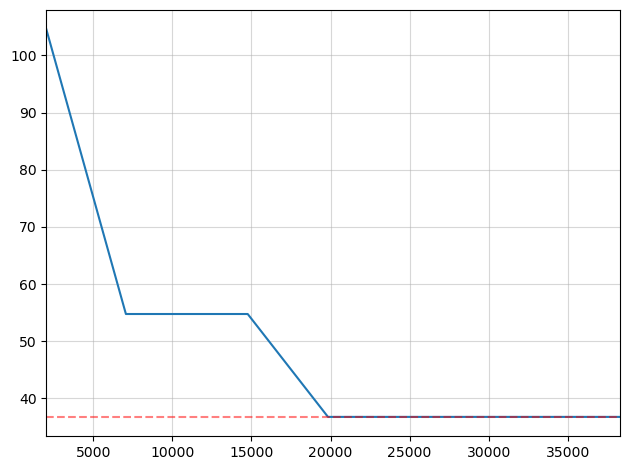

In [178]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [85]:
num_runs = 20
alg_name = 'STML'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = mega_algorithem(obj_func, min_val, max_val, num_variables, 
                                               pop_size_min, pop_size_max, iteration_min, iteration_max)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S

Run 1 Done in 7.74 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 2 Done in 28.79 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 3 Done in 9.00 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 4 Done in 15.70 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 5 Done in 19.30 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 6 Done in 14.17 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 7 Done in 13.38 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 8 Done in 12.06 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 9 Done in 12.70 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 10 Done in 6.62 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 11 Done in 4.55 s; OF: 44.2485


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 12 Done in 6.61 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 13 Done in 18.97 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 14 Done in 18.03 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 15 Done in 8.88 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 16 Done in 4.22 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 17 Done in 8.75 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 18 Done in 10.21 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 19 Done in 8.41 s; OF: 37.2226
Run 20 Done in 15.91 s; OF: 36.7679


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\235090563.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### XXI. Pattern Search (PS)

In [86]:
def init_generator(num_variable, min_val, max_val):
    return np.random.uniform(min_val,max_val,num_variable)

def exploratory_move(X, mu, func):
    array_pos = mu*np.eye(len(X)) + X
    array_neg = -mu*np.eye(len(X)) + X
    mesh = np.concatenate((array_pos, array_neg), axis=0)
    eval_results = np.apply_along_axis(func1d=func, axis=1, arr=mesh)
    eval_results = np.nan_to_num(eval_results, nan=np.inf) #to deal with nan values
    return mesh, eval_results

def pattern_move(current_base, previous_base, alpha, func):
    current_base, previous_base = np.array(current_base), np.array(previous_base)
    X_new = previous_base + alpha*(current_base-previous_base)
    eval_results = func(X_new)
    if np.isnan(eval_results): #to deal with nan values
        eval_results = np.inf
    return X_new, eval_results

def PS_algorithem(mu_const, alpha, delta, obj_func, 
                  final_step_size, num_variable, min_val, max_val):
    results_list = list()
    NFE_list = list()
    NFE_value = 0
    X = init_generator(num_variable, min_val, max_val)
    NFE_value += 1
    best_of = obj_func(X)
    results_list.append(best_of)
    NFE_list.append(NFE_value)
    mu = mu_const
    while mu > final_step_size:
        mesh, values = exploratory_move(X, mu, obj_func)
        NFE_value += 2*num_variable
        if np.min(values) < best_of:
            mu = mu_const
            best_of = np.min(values)
            results_list.append(best_of)
            NFE_list.append(NFE_value)
            current_base = mesh[np.argmin(values)]
            previous_base = X
            while True:
                X_new, of_new = pattern_move(current_base, previous_base, alpha, obj_func)
                NFE_value += 1
                if of_new < best_of:
                    previous_base = current_base
                    current_base, best_of = X_new, of_new
                    results_list.append(best_of)
                    NFE_list.append(NFE_value)
                    mesh, values = exploratory_move(current_base, mu, obj_func)
                    NFE_value += 2*num_variable
                    if np.min(values) < best_of:
                        best_of = np.min(values)
                        results_list.append(best_of)
                        NFE_list.append(NFE_value)
                        previous_base = current_base
                        current_base = mesh[np.argmin(values)]
                else:
                    mu -= delta
                    X = current_base
                    results_list.append(best_of)
                    NFE_list.append(NFE_value)
                    break
        else:
            mu -= delta
            results_list.append(best_of)
            NFE_list.append(NFE_value)             
    return X, best_of, results_list, NFE_list

In [87]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [88]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

mu_const = 15
alpha = 2
delta = .01
final_step_size = .1

In [200]:
start_time = time.time()

X, best_of, results, NFE = PS_algorithem(mu_const, alpha, delta, obj_func, 
                                         final_step_size, num_variables, min_val, max_val)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Best OF ====================
350.4318120998374
Variables ==================
[2.71802315 0.30571866 1.12537885]
Time ======================
Time: 5 min and 19.81 s


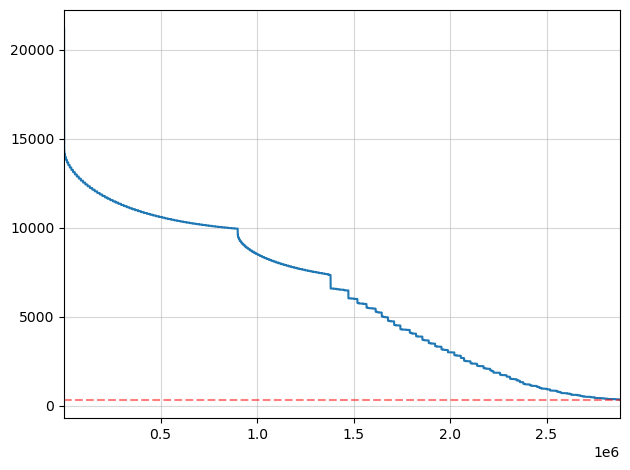

In [201]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [89]:
num_runs = 20
alg_name = 'PS'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = PS_algorithem(mu_const, alpha, delta, obj_func, 
                                             final_step_size, num_variables, min_val, max_val)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(

Run 1 Done in 358.42 s; OF: 316.1417


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 2 Done in 311.43 s; OF: 380.8066


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 3 Done in 1205.16 s; OF: 436.1715


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(

Run 4 Done in 70.36 s; OF: 235.2838


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 5 Done in 1.00 s; OF: nan


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 6 Done in 168.18 s; OF: 729.1965


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 7 Done in 369.66 s; OF: 393.5995


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 8 Done in 37.97 s; OF: 162.4930


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 9 Done in 1.03 s; OF: nan


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 10 Done in 383.45 s; OF: 284.3188


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 11 Done in 40.05 s; OF: 333.4565


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 12 Done in 299.19 s; OF: 376.5765


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 13 Done in 386.02 s; OF: 219.6672


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 14 Done in 51.24 s; OF: 528.7483


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\1033330718.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((O_obs-O_sim)**2)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Lo

Run 15 Done in 204.90 s; OF: 519.4804


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: overflow encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: overflow encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(

Run 16 Done in 20.71 s; OF: 91.8877


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 17 Done in 394.43 s; OF: 264.6340


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 18 Done in 266.29 s; OF: 409.0089


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 19 Done in 129.05 s; OF: 277.7936
Run 20 Done in 392.54 s; OF: 395.6221


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\2495370516.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### XXII. Simulated Annealing (SA)


In [90]:
def init_generator(num_variable, min_val, max_val):
    return np.random.uniform(min_val,max_val,num_variable)

def random_walk(x, epsilon):
    return x + np.random.uniform(-epsilon,epsilon,size=len(x))

def acceptance_function(state,new_state,obj_func,lambda_param):
    of_old = obj_func(state)
    if np.isnan(of_old): #this is to solve nan problem
        of_old = np.inf
    of_new = obj_func(new_state)
    if np.isnan(of_new): #this is to solve nan problem
        of_new = np.inf
    if of_new<=of_old:
        return new_state
    else:
        prob = np.exp(-np.abs(of_old-of_new)/lambda_param)
        rand = np.random.uniform()
        if prob>=rand:
            return new_state
        else:
            return state

def temperature_reduction(initial_lambda,current_iteration,
                          iteration, cooling_factor):
    if 0<cooling_factor<1:
        return initial_lambda*(cooling_factor**current_iteration)
        
def SA_algorithem(obj_func,initial_lambda,num_new_state,
                  num_variable,min_val,max_val,iteration,
                  cooling_factor,epsilon):
    results=np.zeros(iteration)
    NFE=np.zeros(iteration)
    NFE_value=0
    state=init_generator(num_variable,min_val,max_val)
    NFE_value+=1
    lambda_value=initial_lambda
    for i in range(iteration):
        for j in range(num_new_state):
            new_state = random_walk(state,epsilon)
            state = acceptance_function(state,new_state,obj_func,lambda_value)
            NFE_value+=1
        lambda_value=temperature_reduction(initial_lambda,i, iteration,cooling_factor)
        NFE[i]=NFE_value
        results[i]=obj_func(state)
    
    return state, obj_func(state), results, NFE

In [91]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [92]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

num_new_state = 750
iteration = 1500
initial_lambda = 10
cooling_factor = .99
epsilon = 1

In [205]:
start_time = time.time()

X, best_of, results, NFE = SA_algorithem(obj_func,initial_lambda,num_new_state,
                                         num_variables,min_val,max_val,iteration, cooling_factor,epsilon)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_10312\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Best OF ====================
41.98365967140533
Variables ==================
[0.06167367 0.29718327 1.94366931]
Time ======================
Time: 1 min and 43.60 s


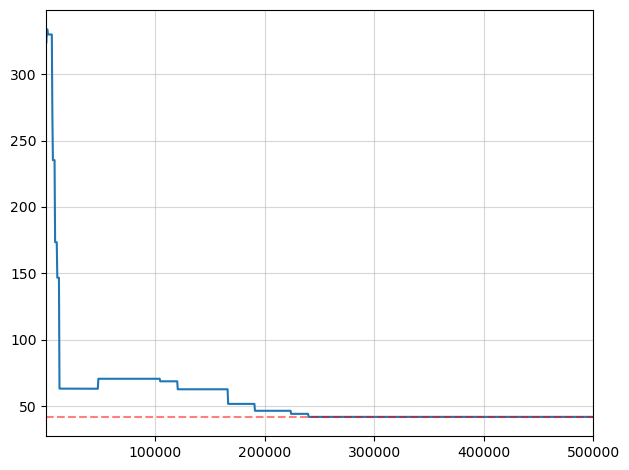

In [206]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [ ]:
O_sim = musk(*X, I, O_obs)

In [ ]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [ ]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

##### Bulk Runs

In [93]:
num_runs = 20
alg_name = 'SA'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = SA_algorithem(obj_func,initial_lambda,num_new_state,
                                             num_variables,min_val,max_val,iteration, cooling_factor,epsilon)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S

Run 1 Done in 279.95 s; OF: 38.9460


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 2 Done in 283.28 s; OF: 38.7608


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 3 Done in 284.01 s; OF: 39.2253


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 4 Done in 251.82 s; OF: 37.8349


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 5 Done in 234.70 s; OF: 37.7009


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


Run 6 Done in 230.39 s; OF: 37.0744


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 7 Done in 233.76 s; OF: 10996.2600


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 8 Done in 235.14 s; OF: 39.1100


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 9 Done in 248.91 s; OF: 44.8627


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 10 Done in 252.00 s; OF: 40.6823


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 11 Done in 262.27 s; OF: 40.1958


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 12 Done in 294.30 s; OF: 42.6723


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 13 Done in 287.43 s; OF: 37.0882


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 14 Done in 275.71 s; OF: 39.9505


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 15 Done in 250.98 s; OF: 40.7592


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 16 Done in 265.41 s; OF: 39.3687


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 17 Done in 245.21 s; OF: 38.8706


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 18 Done in 257.94 s; OF: 39.8188


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 19 Done in 277.97 s; OF: 38.3721
Run 20 Done in 275.78 s; OF: 45.6882


C:\Users\bz267\AppData\Local\Temp\ipykernel_21096\586791400.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,


#### XXIII. Pure Randomness (PR) [Baseline]

In [13]:
def init_genrator(min_val, max_val, num_variables, pop_size):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def boundery_checker(pop, min_val, max_val):
    np.clip(pop, min_val, max_val)
    return np.clip(pop, min_val, max_val)

def sorting_pop(pop, obj_func):
    results = np.apply_along_axis(obj_func, 1, pop)
    indeces = np.argsort(results)
    return pop[indeces]
   
def pure_random(pop_size, iteration, num_variables, obj_func, min_val, max_val):
    NFE_value = 0
    result = np.zeros(iteration)
    NFE = np.zeros(iteration)
    pop = init_genrator(min_val, max_val, num_variables, pop_size)
    for i in range(iteration):
        pop_new = init_genrator(min_val, max_val, num_variables, pop_size)
        overall = np.concatenate((pop, pop_new), axis = 0)
        overall = sorting_pop(overall, obj_func)
        pop = overall[:pop_size]
        NFE_value += (pop_size*2)
        result[i] = obj_func(pop[0])
        NFE[i] = NFE_value
    return pop[0], obj_func(pop[0]), result, NFE

In [14]:
db = pd.read_csv('wilson.csv')
t = np.array(db.t)
I = np.array(db.I)
O_obs = np.array(db.O)

In [41]:
min_val, max_val = [0.01, 0.01, 1], [1, .5, 3]
num_variables = 3

pop_size = 300
iteration = 800

In [42]:
start_time = time.time()

X, best_of, results, NFE = pure_random(pop_size, iteration, num_variables, obj_func, min_val, max_val)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Best OF ====================
37.66501407648289
Variables ==================
[0.07954483 0.28383287 1.88747535]
Time ======================
Time: 0 min and 45.64 s


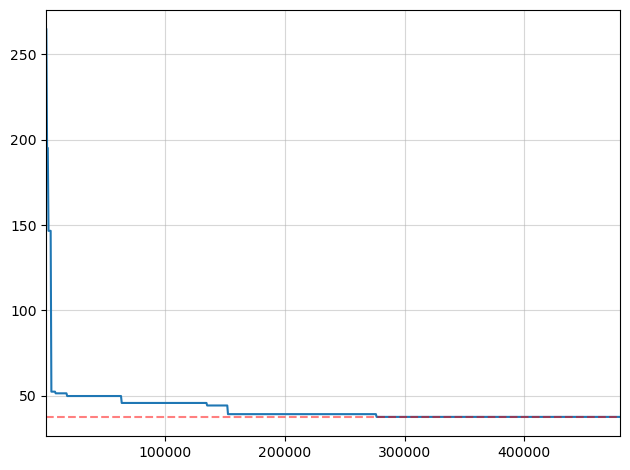

In [43]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [44]:
O_sim = musk(*X, I, O_obs)

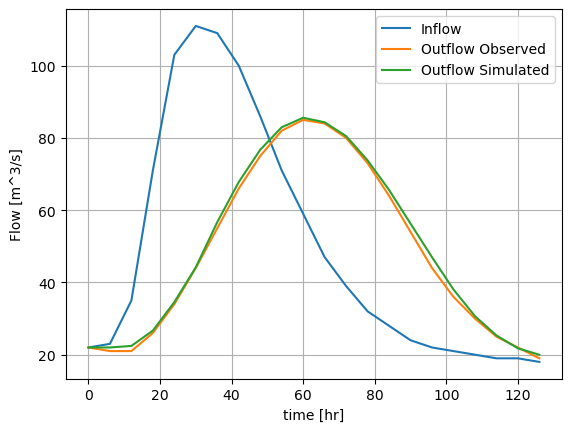

In [45]:
t_hr = t/3600
fig = plt.plot(t_hr, I, label='Inflow')
fig = plt.plot(t_hr, O_obs, label='Outflow Observed')
fig = plt.plot(t_hr, O_sim, label='Outflow Simulated')
fig = plt.xlabel('time [hr]')
fig = plt.ylabel('Flow [m^3/s]')
fig = plt.legend()
fig = plt.grid()

In [47]:
SSD = np.sum(np.square(O_obs-O_sim))
NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))

msg = f'''Result Analysis:
=====================
SSD:\t\t%.2f
NSE:\t\t%.2f
====================='''%(SSD, NSE)

print(msg)

Result Analysis:
SSD:		37.67
NSE:		1.00


##### Bulk Runs

In [48]:
num_runs = 20
alg_name = 'PR'
root_directory = 'C:/Users/bz267/Optimization results/Engineering Benchmark/Hydrology/Muskingum'

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'SSD', 'NSE', 'Parameters'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = pure_random(pop_size, iteration, num_variables, obj_func, min_val, max_val)
    end_time = time.time()
    O_sim = musk(*X, I, O_obs)
    SSD = np.sum(np.square(O_obs-O_sim))
    NSE = 1-(np.sum(np.square(O_obs-O_sim))/np.sum(np.square(O_obs - O_obs.mean())))
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'SSD': SSD, 'NSE': NSE,
                                            'Parameters':{'K':X[0],'X': X[1], 'm':X[2]}},
                                           ignore_index=True)
    print('Run %d Done in %.2f s; OF: %.4f'%(i+1, end_time-start_time, best_of))

folder_name = '/Example 1 - Wilson/'
file_name = '%s_result.csv'%alg_name
output_dir = Path(root_directory+folder_name)
output_dir.mkdir(parents=True, exist_ok=True)
overall_result.to_csv(output_dir / file_name)

C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(

Run 1 Done in 46.19 s; OF: 37.9575


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 2 Done in 52.86 s; OF: 39.5072


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 3 Done in 51.28 s; OF: 38.0385


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 4 Done in 46.29 s; OF: 41.3941


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 5 Done in 45.93 s; OF: 39.6677


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 6 Done in 46.16 s; OF: 40.1065


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 7 Done in 47.86 s; OF: 41.3702


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 8 Done in 479.64 s; OF: 38.2054


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 9 Done in 50.02 s; OF: 39.3354


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 10 Done in 48.46 s; OF: 40.1998


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 11 Done in 45.61 s; OF: 37.3403


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 12 Done in 46.19 s; OF: 37.1276


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 13 Done in 50.98 s; OF: 38.3513


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 14 Done in 45.94 s; OF: 36.8448


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 15 Done in 46.01 s; OF: 37.3537


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 16 Done in 45.91 s; OF: 37.2909


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 17 Done in 46.24 s; OF: 38.9498


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 18 Done in 46.68 s; OF: 39.3171


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:9: RuntimeWarning: invalid value encountered in double_scalars
  O_sim[i+1] = (((S[i+1]/K)**(1/m))-chi*I[i])/(1-chi)
C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\506879750.py:7: RuntimeWarning: invalid value encountered in double_scalars
  change_rate_S = (1/(1-chi))*(I[i]-(S[i]/K)**(1/m))


Run 19 Done in 46.50 s; OF: 38.4715
Run 20 Done in 47.51 s; OF: 37.5002


C:\Users\bz267\AppData\Local\Temp\ipykernel_25564\1166404654.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
